# Chord Recognition Algorithm

Finding chord names from a given audio file.

## Files

"Chords.m4a" and "Chords.ogg" = audio file of chords being played on a piano

"Chord_Progressions.pdf" = written out chords from the audio files, the number in the following variable names correspond with the measure numbers in this file (i.e. c6 = segment of the audio file featuring the chord from measure 6)

## Background

#### General:
We both have prior knowledge in music theory concepts through the College of Fine Arts.

#### General terms:

Pitch classes = all pitches within an octave (C C#/Db D D#/Eb E F F#/Gb G G#/Ab A A#/Bb B)

Whole Step =  Looking at a piano keyboard, notes are two keys away from each other

Half Step = Looking at a piano keyboard, notes are one key away from each other

Enharmonic = Notes that can be "spelled" differently but represent the same pitch (i.e. D# and Eb and Fbb, C and B#, etc.). Although this can seem unnecessary redundant this project, it can help with consistency of key signatures in written music.

Major Triad = A three note chord where given a base, the second note is four half steps above the base, and the third note is four half steps above the second note

Minor Triad = A three note chord where given a base, the second note is three half steps above the base, and the third note is four half steps above the second note

Dominant 7th (can be represented with 7) = A four note chord where given a base, the second note is four half steps above the base, the third note is three half steps above the second note, and the fourth note is three half steps above the third note.

Half Diminished (can be represented with ø) = A four note chord where given a base, the second note is three half steps above the base, the third note is three half steps above the second note, and the fourth note is four half steps above the third note.

Diminished (can be represented with o7) = A four note chord where given a base, each following note is three half steps above the preceding note.

#### Readings:

- ["Automatic Chord Recognition for Music Classification and Retrieval"][1] 
- ["Visualizing Sounds Using Librosa Machine Learning Library!"][2] (We adapted some code from here to display the chromagraphs)
- ["An Expert Ground-Truth Set for Audio Chord Recognition and Music Analysis"][3]
- [From class: Lecture 18][4]
- Fundamentals of Music Processing by Meinard Müller - Chapter 5: Chord Recognition

[1]: https://users.ece.cmu.edu/~hengtzec/papers/icme08_chord.pdf "Automatic Chord Recognition for Music Classification and Retrieval"
[2]: https://www.analyticsvidhya.com/blog/2021/06/visualizing-sounds-librosa/ "Visualizing Sounds Using Librosa Machine Learning Library!"
[3]: https://ismir2011.ismir.net/papers/OS8-1.pdf "An Expert Grount-Truth Set for Audio Chord Recognition and Music Analysis"
[4]: https://www.cs.bu.edu/fac/snyder/cs583/Lectures/Lecture%2018.pdf "Lecture 18"

In [33]:
# General useful imports
import numpy as np
import matplotlib.pyplot as plt
import librosa 
import librosa.display
from IPython.display import Audio

from scipy import signal
from scipy.signal import find_peaks, windows

%matplotlib inline


# Basic audio parameters

SR = 22050 #  sample rate default for Librosa


# Round to 4 decimal places
def round4(x):
    return np.around(x,4)  

## Code to Display a Melody File and Create a Spectrogram and Chromagraph


In [34]:
def displaySignal(x, sr=SR, title='Signal X'):
    plt.figure(figsize=(12,6))
    plt.title(title)
    plt.plot([0,librosa.get_duration(x)],[0,0],linewidth=1,color='k')
    plt.grid() # gridlines
    librosa.display.waveshow(x,sr=sr)
    plt.show() 

### Displays Chroma of signal

In [35]:
def displaySpectroChroma(x, sr=SR, y_axis='linear'): #y_axis="log"
    
    S = np.abs(librosa.stft(x)) # calculate the 2D spectrogram
    Sdb = librosa.amplitude_to_db(S, ref=np.max) # will show power spectrum in heatmap

    plt.figure(figsize=(12,6))
    plt.title("Spectrogram")
    librosa.display.specshow(Sdb, sr=SR, x_axis='time', y_axis=y_axis)
    plt.colorbar(format='%+2.0f dB')
    plt.show()


    S = np.abs(librosa.stft(x, n_fft=4096))**2
    chroma = librosa.feature.chroma_stft(S=S, sr=SR)

    plt.figure(figsize=(12,6))
    plt.title("Chromagraph")
    img = librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
    plt.show()

In [36]:
# create a dictionary of pitch class notes
notenames = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

In [37]:
# returns chroma as a numpy array of length 12
def get_chroma(x, sr=SR, window_size=4096, display=True):
    # power spectrum
    #c = librosa.feature.chroma_stft(y=x, sr=sr,n_fft=window_size,hop_length=len(x)+1)
    
    # magnitude spectrum
    #S = np.abs(librosa.stft(x))
    #c = librosa.feature.chroma_stft(S=S, sr=sr,n_fft=window_size,hop_length=len(x)+1)
    
    # Use a pre-computed power spectrogram 
    S = np.abs(librosa.stft(x, n_fft=window_size))**2
    c = librosa.feature.chroma_stft(S=S, sr=sr,n_fft=window_size,hop_length=len(x)+1)
    
    c = (c.T)[0]
    
    if display:
        print("\nNote\tChroma Energy")
        for k in range(12):
            print(notenames[k],"\t", c[k])

        plt.title("Chroma")
        x = notenames
        x_pos = [i for i, _ in enumerate(x)]
        plt.bar(x_pos, c)
        plt.xlabel("Note")
        plt.ylabel("Chroma Energy")
        plt.xticks(x_pos, x)
        plt.show()
        
    return c

In [38]:
# Make the chord templates for 12 major and 12 minor triads. (from Muller's book)
def generate_chord_templates(nonchord=False):
    """Generate chord templates of major and minor triads, dominant seventh, half diminished, and diminished
    """
    # template based on C
    mode_templates = [(np.array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]), "M"), # major triad
                      (np.array([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]), "m"), # minor triad
                      (np.array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0]), "7"), # dominant 7th (major triad + minor 7th)
                      (np.array([1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0]), "ø"), # half diminished (diminished triad + minor 7th)
                      (np.array([1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0]), "o7")] # fully diminished (diminished triad + diminished 7th)
    
    chord_templates = []
    chord_names = []
    
    for i in range(len(mode_templates)):
        template, mode = mode_templates[i]
        for k in range(len(notenames)):
            chord_names.append(notenames[k] + mode)
            chord_templates.append(np.roll(template, k))
        
    chord_names = np.array(chord_names)
    chord_templates = np.array(chord_templates)
    return chord_names, chord_templates



chord_names, chord_templates = generate_chord_templates()

print("Chord\t Template")
print("\t  C C#D D#E F F#G G#A A#B")
for i in range(len(chord_templates)):
    print(chord_names[i], "\t", chord_templates[i])
    


Chord	 Template
	  C C#D D#E F F#G G#A A#B
CM 	 [1 0 0 0 1 0 0 1 0 0 0 0]
C#M 	 [0 1 0 0 0 1 0 0 1 0 0 0]
DM 	 [0 0 1 0 0 0 1 0 0 1 0 0]
D#M 	 [0 0 0 1 0 0 0 1 0 0 1 0]
EM 	 [0 0 0 0 1 0 0 0 1 0 0 1]
FM 	 [1 0 0 0 0 1 0 0 0 1 0 0]
F#M 	 [0 1 0 0 0 0 1 0 0 0 1 0]
GM 	 [0 0 1 0 0 0 0 1 0 0 0 1]
G#M 	 [1 0 0 1 0 0 0 0 1 0 0 0]
AM 	 [0 1 0 0 1 0 0 0 0 1 0 0]
A#M 	 [0 0 1 0 0 1 0 0 0 0 1 0]
BM 	 [0 0 0 1 0 0 1 0 0 0 0 1]
Cm 	 [1 0 0 1 0 0 0 1 0 0 0 0]
C#m 	 [0 1 0 0 1 0 0 0 1 0 0 0]
Dm 	 [0 0 1 0 0 1 0 0 0 1 0 0]
D#m 	 [0 0 0 1 0 0 1 0 0 0 1 0]
Em 	 [0 0 0 0 1 0 0 1 0 0 0 1]
Fm 	 [1 0 0 0 0 1 0 0 1 0 0 0]
F#m 	 [0 1 0 0 0 0 1 0 0 1 0 0]
Gm 	 [0 0 1 0 0 0 0 1 0 0 1 0]
G#m 	 [0 0 0 1 0 0 0 0 1 0 0 1]
Am 	 [1 0 0 0 1 0 0 0 0 1 0 0]
A#m 	 [0 1 0 0 0 1 0 0 0 0 1 0]
Bm 	 [0 0 1 0 0 0 1 0 0 0 0 1]
C7 	 [1 0 0 0 1 0 0 1 0 0 1 0]
C#7 	 [0 1 0 0 0 1 0 0 1 0 0 1]
D7 	 [1 0 1 0 0 0 1 0 0 1 0 0]
D#7 	 [0 1 0 1 0 0 0 1 0 0 1 0]
E7 	 [0 0 1 0 1 0 0 0 1 0 0 1]
F7 	 [1 0 0 1 0 1 0 0 0 1 0 0]
F#7 	 [0 1 0 0 

In [39]:
def distance(chroma, template, kind='L2'): # default is L2 norm
    if(kind == 'L1'):
        return np.sum(np.abs(chroma-template))
    elif(kind == 'L2'):
        return (np.sum((chroma-template)**2))**0.5
    elif(kind == 'CD'): # Correlation Distance:  1 + correlation
        s = np.std(chroma) # must account for inputs with all 0's
        sn = np.std(template)
        if(np.isclose(s,0) or np.isclose(sn,0)):
            return 0.0
        else:
            return 1.0 - (((chroma - np.mean(chroma)) @ (template - np.mean(template))) / (len(chroma) * s * sn))              
    else:
        return None

In [84]:
# apply distance function to chroma and all possible chords, and print array of 24 distances
def apply_chord_templates(chroma, dist="L2", chord_names=chord_names, chord_templates=chord_templates, display=True):
#     if(display):
#         print("Chord\t Score")
    n = 0
    min_score = 1000000
    scores = []
    
    for k in range(len(chord_names)):
        s = distance(chroma, chord_templates[k], kind=dist)
        scores.append(s)
#         if(display):
#             print( chord_names[k], "\t", s )
        if(s < min_score):
            n = k
            min_score = s
            
    if(display):
        plt.figure(figsize=(20,6))
        plt.title("Chord Distances")
        x = chord_names
        x_pos = [i for i, _ in enumerate(x)]
        plt.bar(x_pos, scores)
        plt.xlabel("Chord")
        plt.ylabel("Distance from Chroma")
        plt.xticks(x_pos, x)
        plt.show()

        print("\nClosest template: ",chord_names[n], "with distance", round4(min_score))
        
    return (chord_names[n],min_score)



# Graphs for Chord Audios

Linsy recorded all the chords found in "Chords.m4a" on a piano in a CFA practice room :)

In [41]:
try:
    x, sr = librosa.load("Chords.m4a")
except:
    x, sr = librosa.load("Chords.ogg") # in case .m4a doesn't work

/Users/linsywang/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


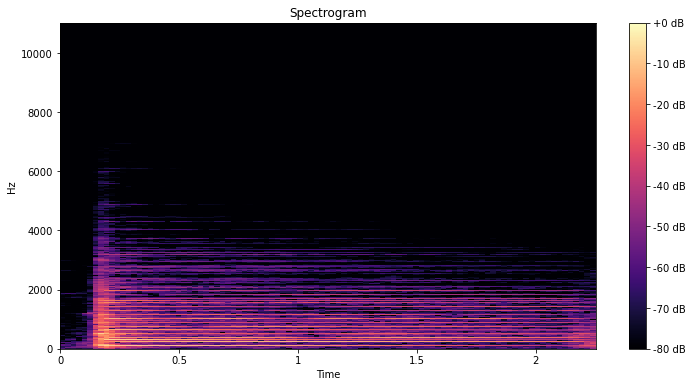

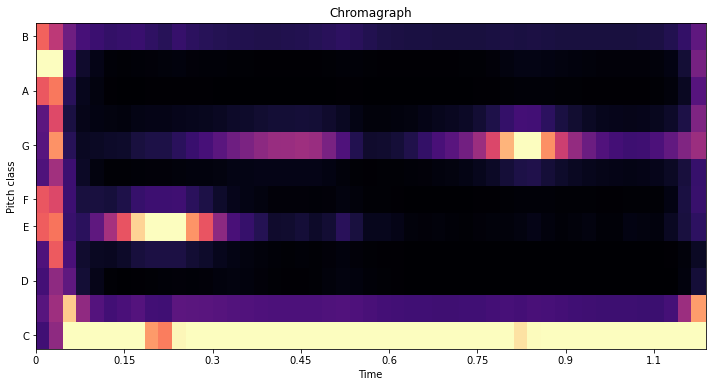

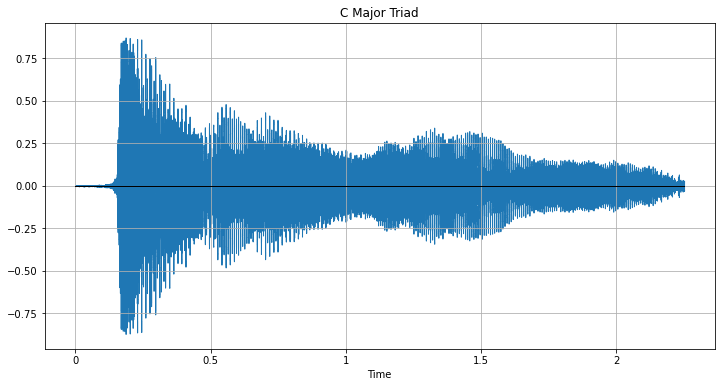

In [80]:
c1 = x[int(4.75*SR):int(7*SR)]

displaySpectroChroma(x = c1)

displaySignal(c1, title="C Major Triad")
Audio(c1, rate=sr)

The first issue we ran into was that noise at the beginning and end of a chord sound can mess with the chromagraph. We manually removed the beginning and end of the audio file so that the readings could be more accurate.

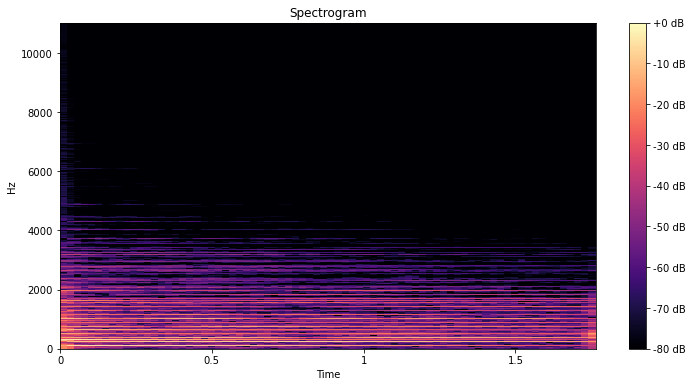

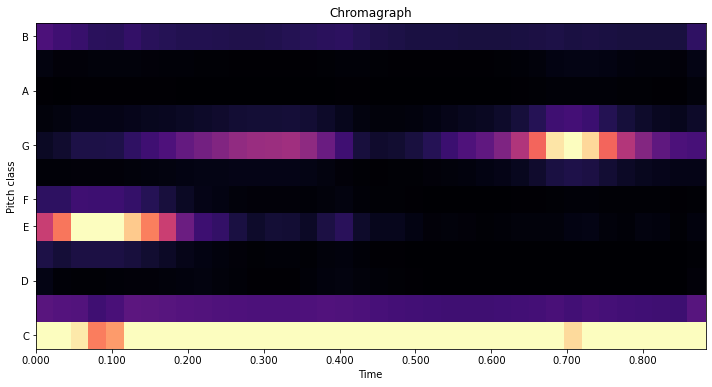

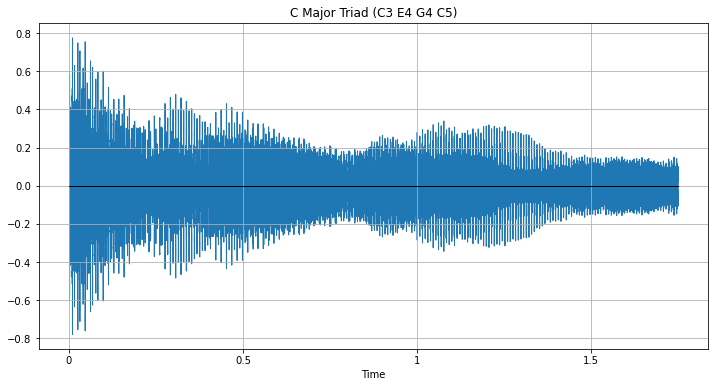

In [43]:
c1 = x[int(5*SR):int(6.75*SR)]

displaySpectroChroma(x = c1)

displaySignal(c1, title="C Major Triad (C3 E4 G4 C5)")
Audio(c1, rate=sr)


### Analyzing Chroma Energy
In this bar graph below, you can see that while C and E were correctly picked out, we have some false flags like C# and B. Two possible causes of this are:

(a) Extra noise: Since we weren't recording in a soundproof environment with high-quality mics, the algorithm is bound to produce some incorrect readings due to low-quality audio.

(b) Overtones: For example, E was one of our main detected pitches. A prominent overtone of a note is typically seven half steps above that note's pitch. In this case, seven half steps above E is B.
    



Note	Chroma Energy
C 	 1.0
C# 	 0.27238977
D 	 0.037970424
D# 	 0.12738807
E 	 0.5466125
F 	 0.17022216
F# 	 0.017183548
G 	 0.07087622
G# 	 0.025209859
A 	 0.0074069216
A# 	 0.031277575
B 	 0.24127382


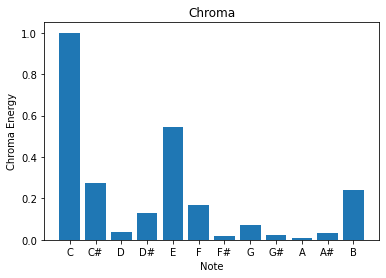

array([1.        , 0.27238977, 0.03797042, 0.12738807, 0.5466125 ,
       0.17022216, 0.01718355, 0.07087622, 0.02520986, 0.00740692,
       0.03127757, 0.24127382], dtype=float32)

In [44]:
get_chroma(c1)

The original code from Lecture 18 covers the 12 major and minor triads. In addition to those, we expanded the chord templates to cover dominant seventh, half diminished, and fully diminished chords as well.

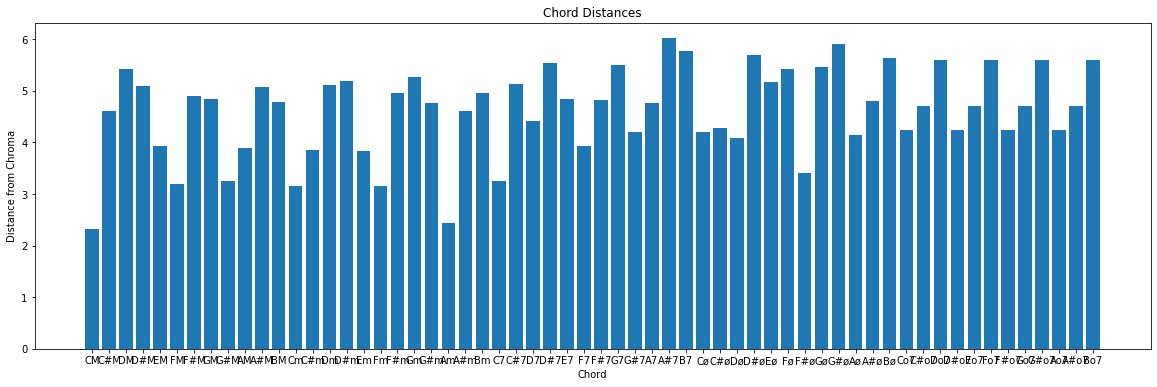


Closest template:  CM with distance 2.3128


In [85]:
(_,_) = apply_chord_templates(ch,dist="L1")

Next, we tried different voicings of C Major to see if it would affect our results. We wrote this function so that we wouldn't have to repeat redundant code:

In [114]:
# prints spectrogram, chromagraph, signal, audio, and algorithm guess for a given audio file input 
def printResults(signal, title = "placeholder title", get_chromaDisplay = False, apply_chord_templatesDisplay = False):
    displaySpectroChroma(x = signal)
    displaySignal(signal, title = title)
    display(Audio(signal, rate=sr))
    (chord, _) = apply_chord_templates(get_chroma(signal, display = get_chromaDisplay),dist="L1", display = apply_chord_templatesDisplay)
    print("Predicted Chord: ", chord) 

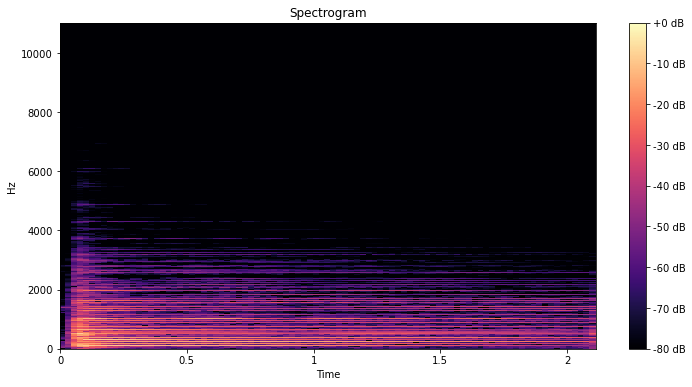

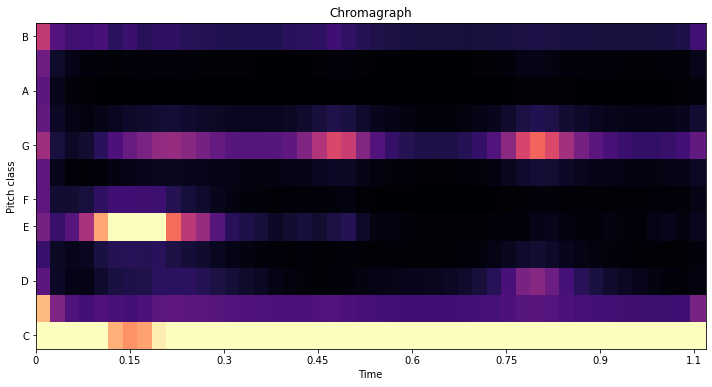

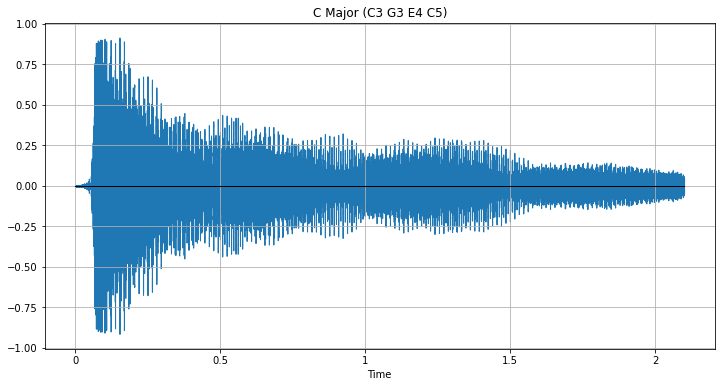

Predicted Chord:  CM


In [92]:
c2 = x[int(7.6*SR):int(9.7*SR)]
printResults(c2, title = "C Major (C3 G3 E4 C5)")

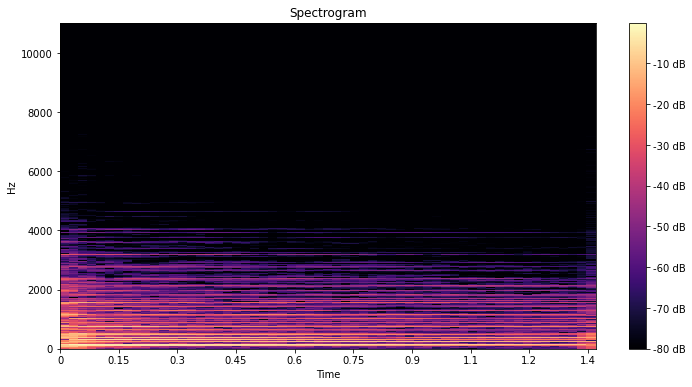

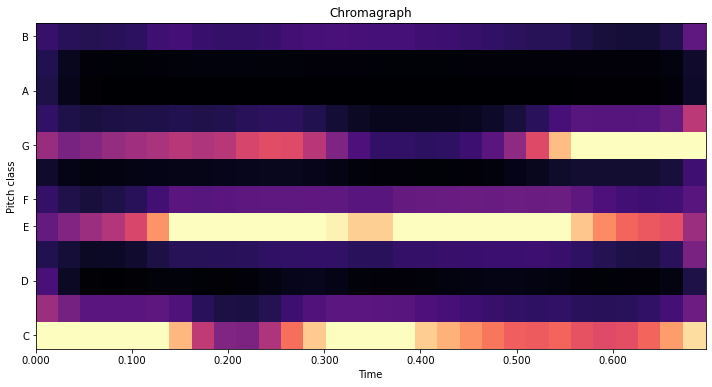

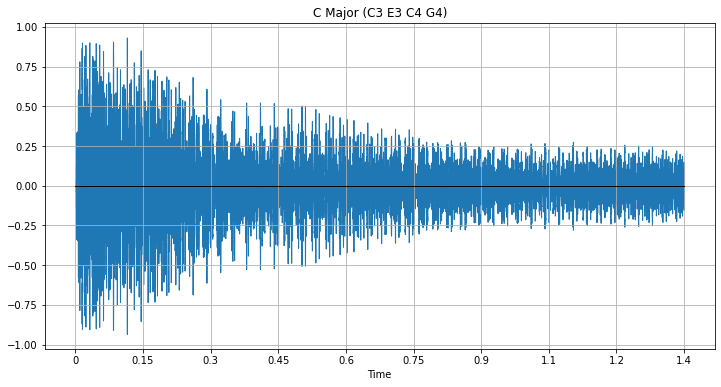

Predicted Chord:  CM


In [93]:
c3 = x[int(10.4*SR):int(11.75*SR)]
printResults(c3, title = "C Major (C3 E3 C4 G4)")

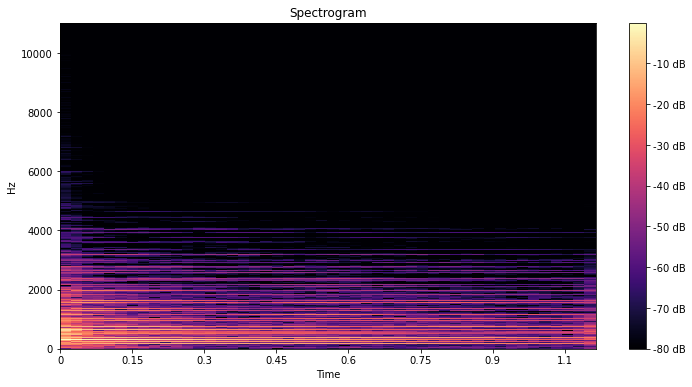

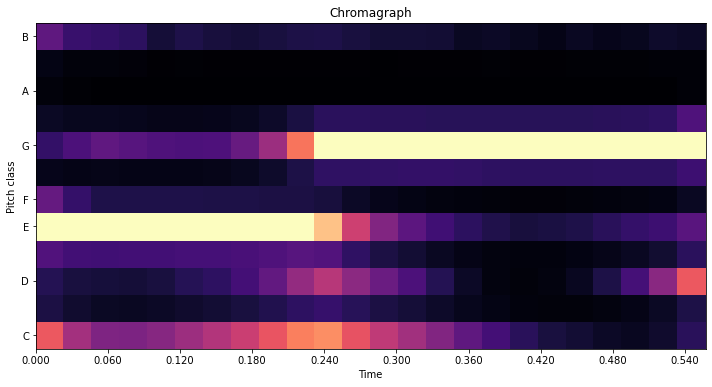

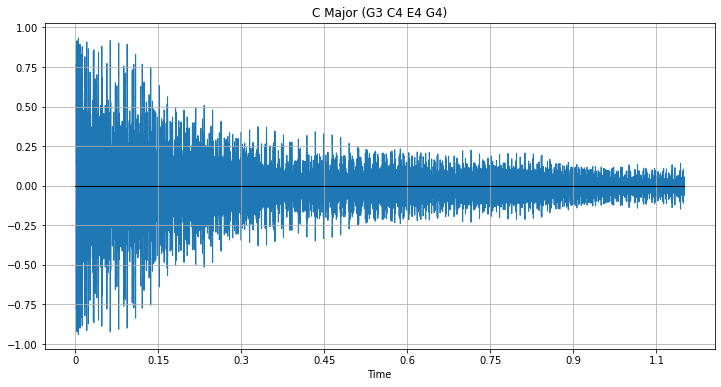

Predicted Chord:  CM


In [95]:
c4 = x[int(13*SR):int(14.1*SR)]
printResults(c4, title = "C Major (G3 C4 E4 G4)")

C major seems to register correctly regardless of voicing or inversion. We did notice that results were a little off before cutting noise from the audio. The chord predictions inclided A minor which does include two of the same notes as a C Major triad and is the relative minor for C Major. However, B half diminished and D minor were also predicted, which are not as closely related to C Major. Ultimately, cutting out the noise significantly improved the results. This may become more complex when analyzing chord changes, which will be shown a little later on. 

Below we analyze C minor chords, where only the middle note of the triad (E) is shifted a half step down to become Eb.

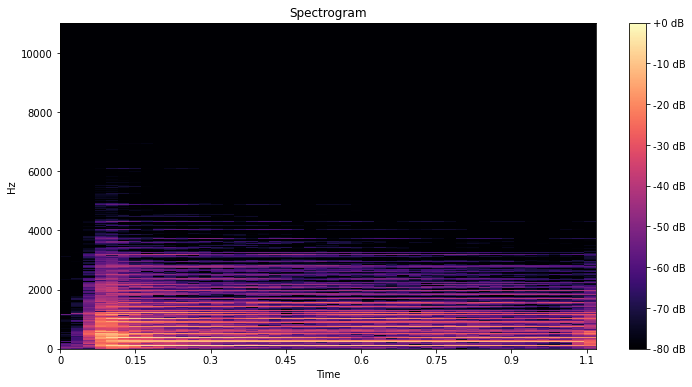

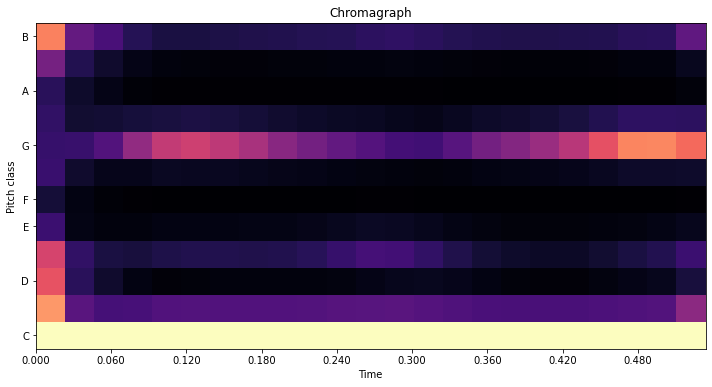

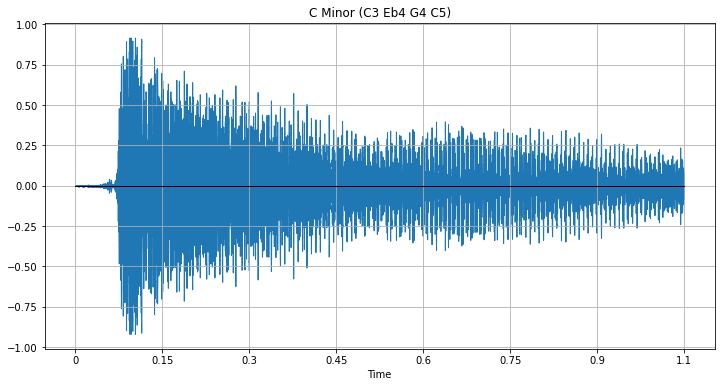

Predicted Chord:  Cm


In [96]:
c5 = x[int(20.45*SR):int(21.5*SR)]
printResults(c5, title = "C Minor (C3 Eb4 G4 C5)") # without cut: A# half diminished

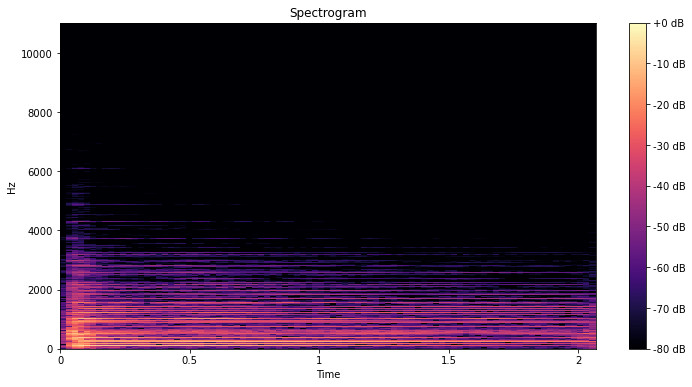

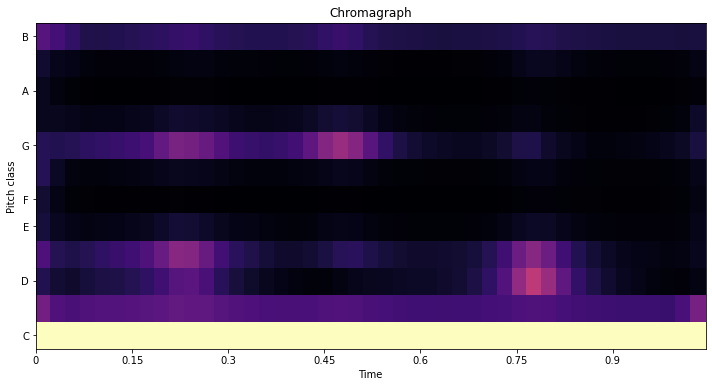

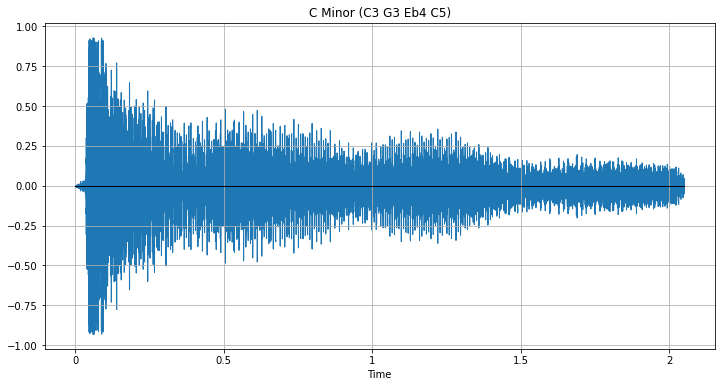

Predicted Chord:  Cm


In [97]:
c6 = x[int(22.7*SR):int(24.75*SR)]
printResults(c6, title = "C Minor (C3 G3 Eb4 C5)") # without cut: Gm

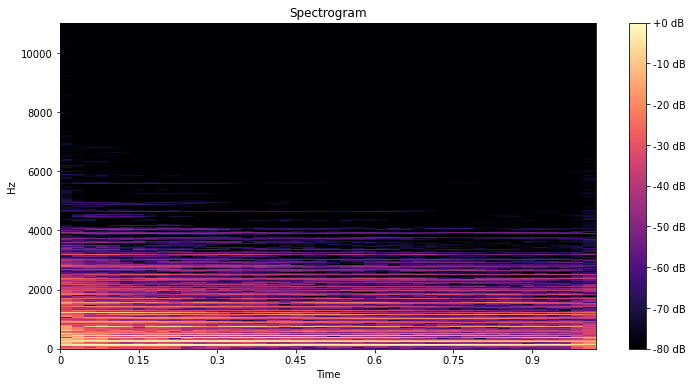

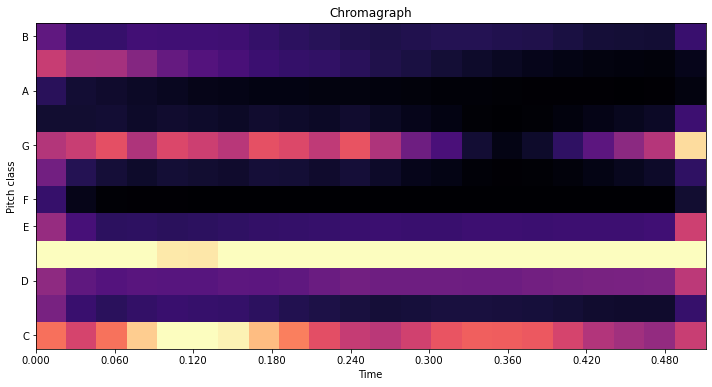

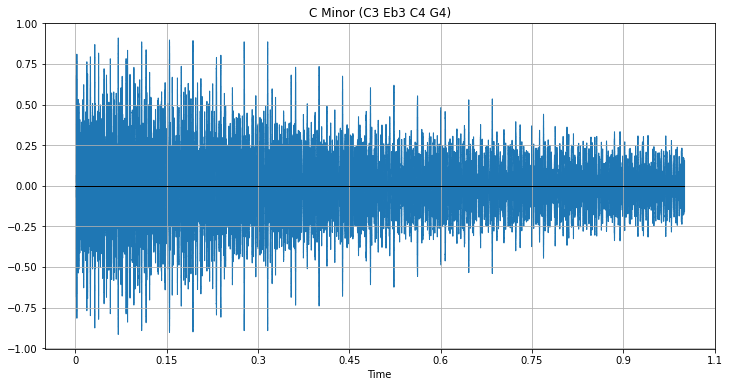

Predicted Chord:  Cm


In [98]:
c7 = x[int(25.4*SR):int(26.4*SR)]
printResults(c7, title = "C Minor (C3 Eb3 C4 G4)") # without cut: B7

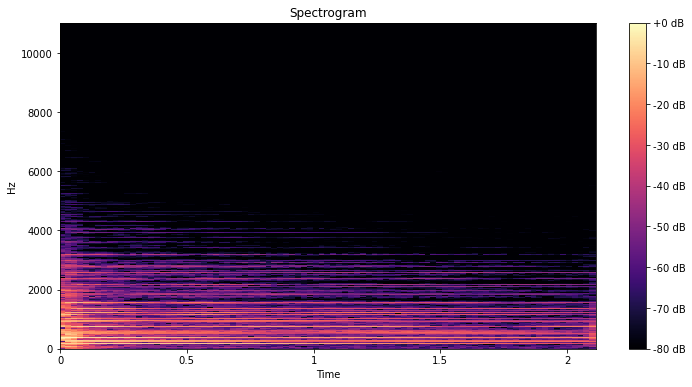

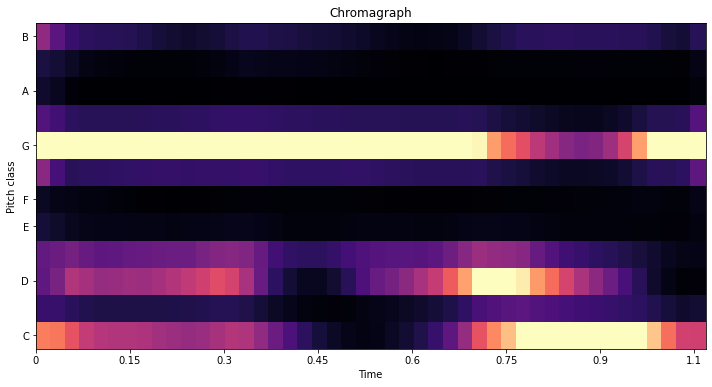

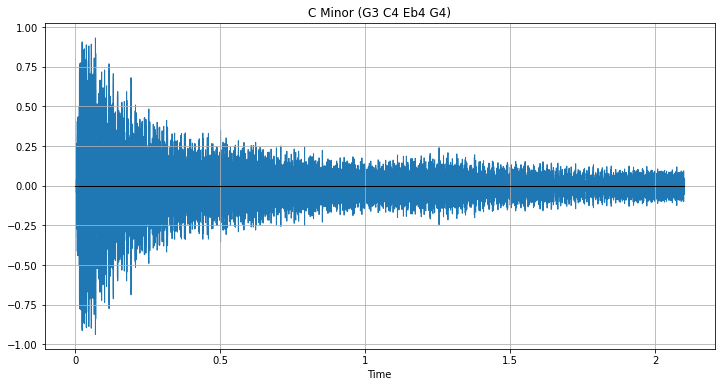

Predicted Chord:  Cm


In [99]:
c8 = x[int(30.2*SR):int(32.3*SR)]
printResults(c8, title = "C Minor (G3 C4 Eb4 G4)") # without cut: G#m

The algorithm seems accurate interpreting the various C major and C minor chords. 

Below we analyze C7 chords, which includes the notes of a C Major triad combined with a Bb.

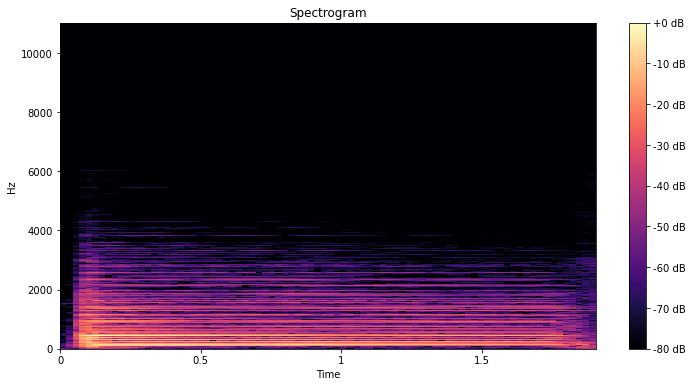

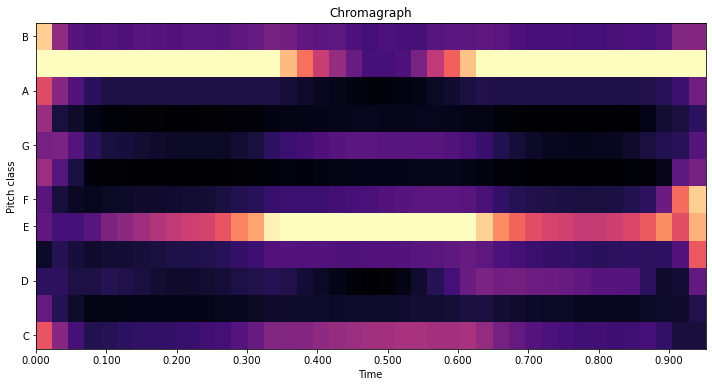

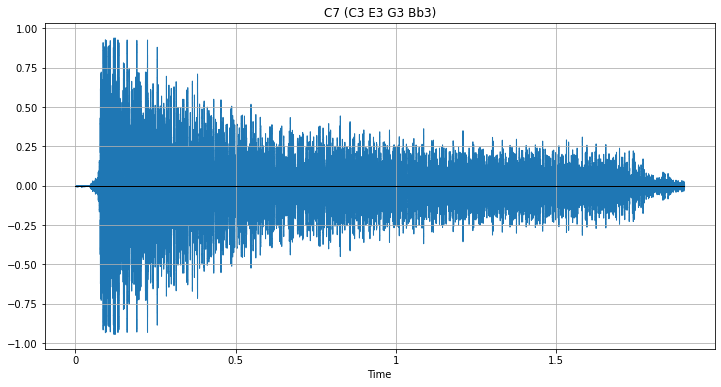

Predicted Chord:  C7


In [103]:
c9 = x[int(35.5*SR):int(37.4*SR)] 
printResults(c9, title = "C7 (C3 E3 G3 Bb3)")

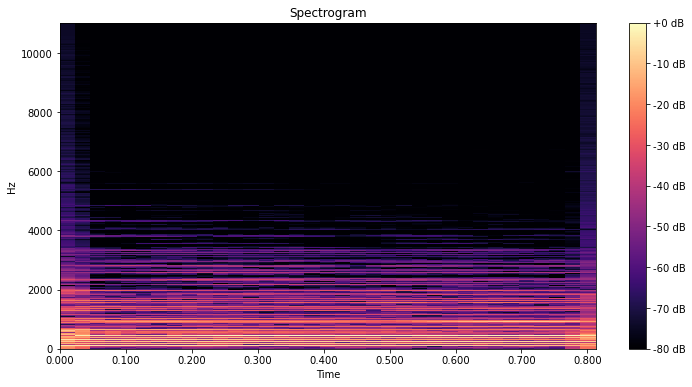

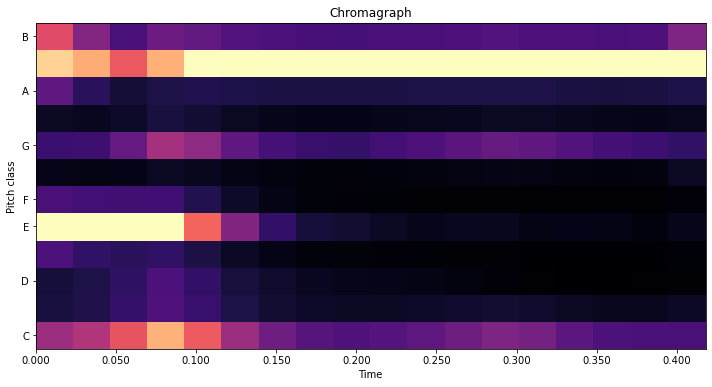

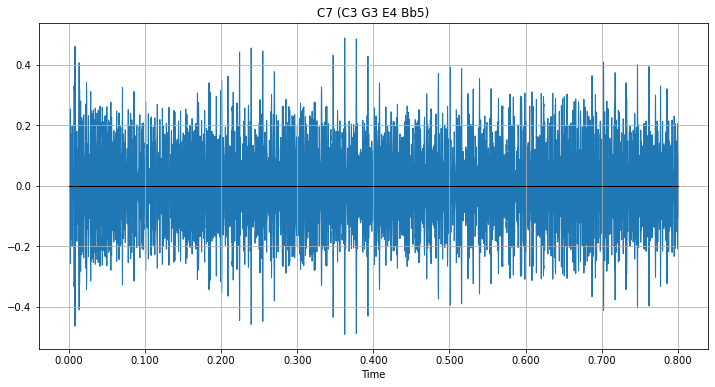

Predicted Chord:  C7


In [104]:
c10 = x[int(38.1*SR):int(38.9*SR)]
printResults(c10, title = "C7 (C3 G3 E4 Bb5)") # without cut: E7

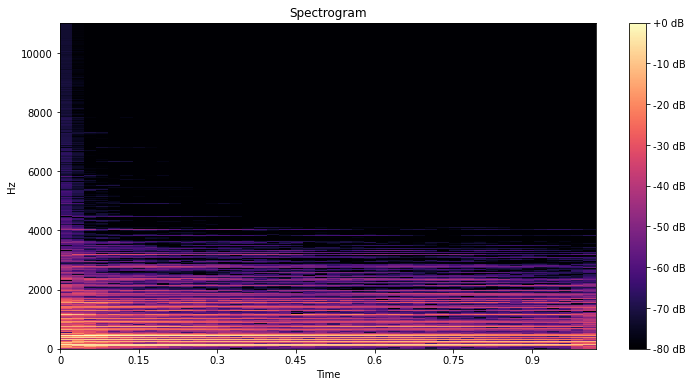

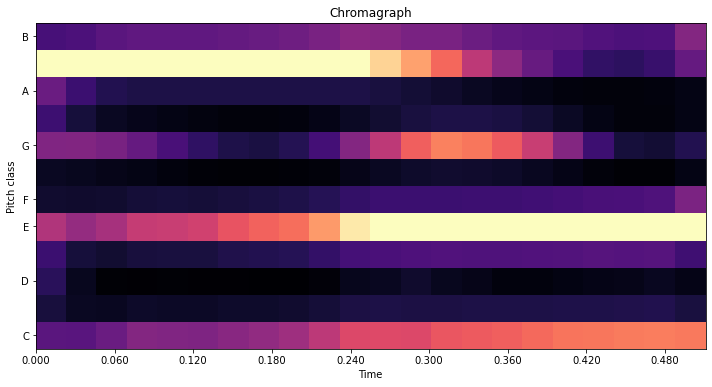

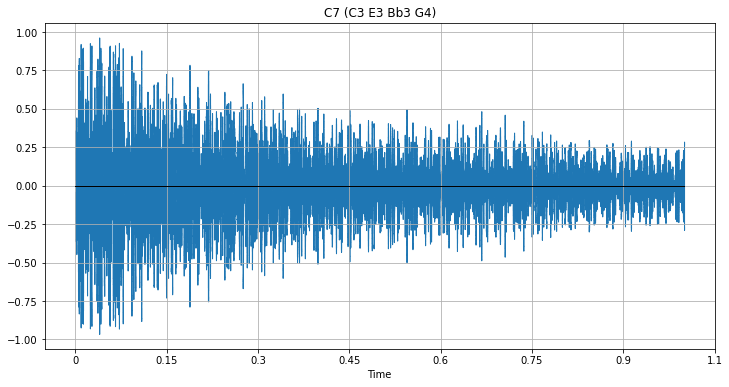

Predicted Chord:  C7


In [105]:
c11 = x[int(40.4*SR):int(41.4*SR)]
printResults(c11, title = "C7 (C3 E3 Bb3 G4)") # without cut: Am

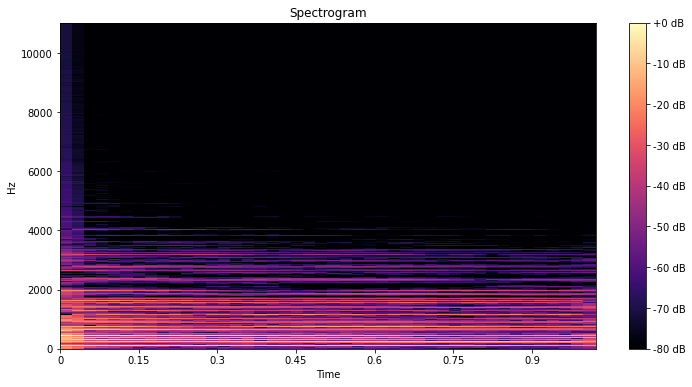

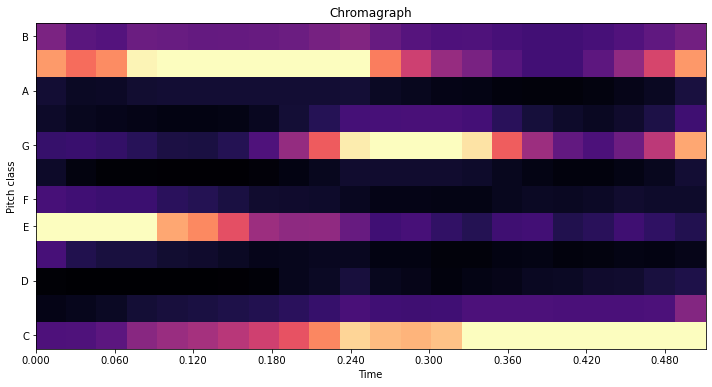

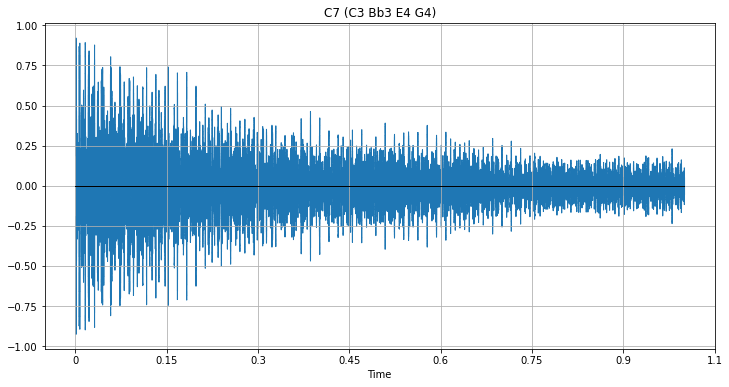

Predicted Chord:  C7


In [106]:
c12 = x[int(42.8*SR):int(43.8*SR)]
printResults(c12, title = "C7 (C3 Bb3 E4 G4)") # without cut: F major

In order for the chord to sound more clearly, these audios required longer cuts from the beginning and end compared to the previous types of chords. This could make writing an autocutting algorithm to automatically cuts the audio more difficult.

Nevertheless, C7 seemed to be comprehendable by the algorithm. The prominence of the seventh of the chord (Bb) may make it easier to be detect by the algorithm; as the Bb is very bright in each Chromagraph.

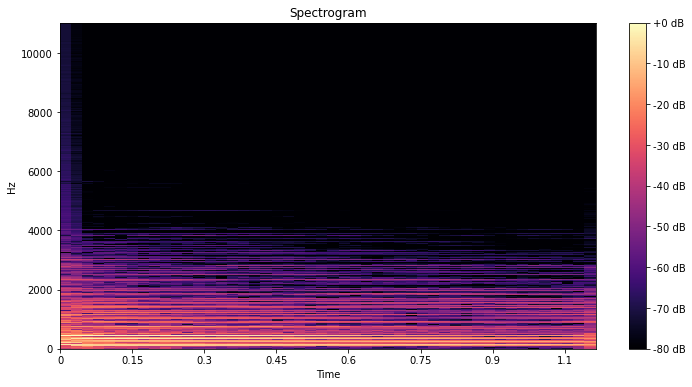

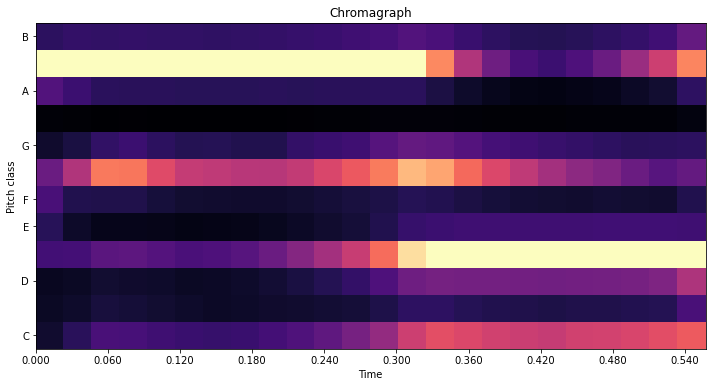

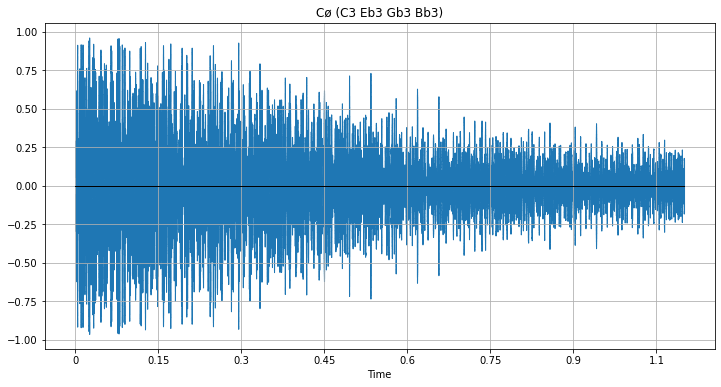

Predicted Chord:  D#m


In [116]:
c13 = x[int(47.9*SR):int(49*SR)]
printResults(c13, title = "Cø (C3 Eb3 Gb3 Bb3)") # without cut: F half diminished

In this example, the algorithm predicts D# minor for a C half diminished chord. 

The notes in a D# minor chord are: D# F# A# 

This can enharmonically be an Eb minor chord: Eb Gb Bb
                              
The notes in a C half diminished chord are: C Eb Gb Bb

The algorithm seemed to get confused by the overlapped similarity between these two chords. In addition, the C does not seem too prominent within the chromagraph. One thing that could solve the issue in this case would be to give the program the bass note, which would have been C, and help push the algorithm to predict Cø.

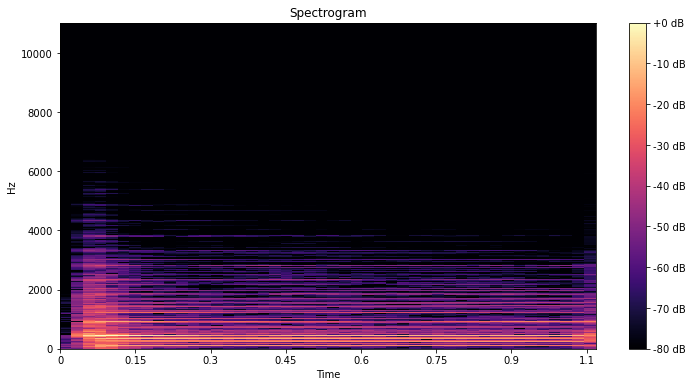

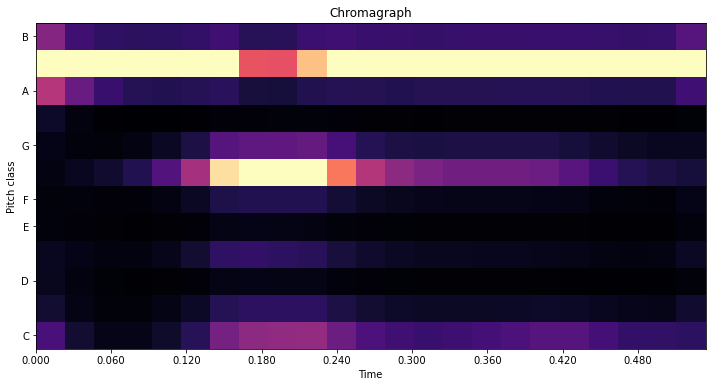

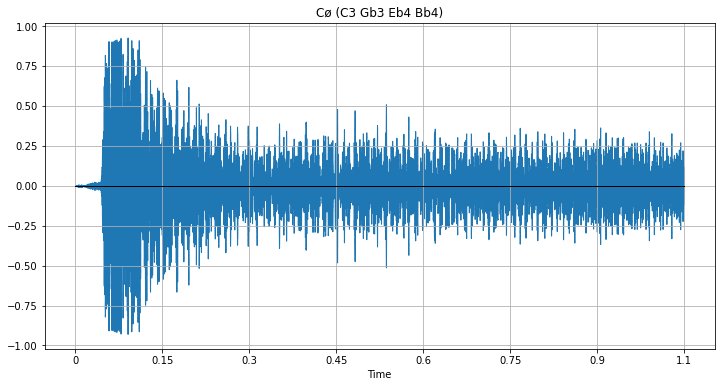

Predicted Chord:  F#M


In [108]:
c14 = x[int(50.15*SR):int(51.2*SR)]
printResults(c14, title = "Cø (C3 Gb3 Eb4 Bb4)") # without cut: C minor

The notes of F# major triad are: F# A# C#
This can enharmonic be a Gb major triad: Gb Bb Db

It seems like the C and Eb are barely registered. The algorithm picked up more on the Gb and Bb, which is a GbM (enharmonically F#M) triad without a third triad note (Db).

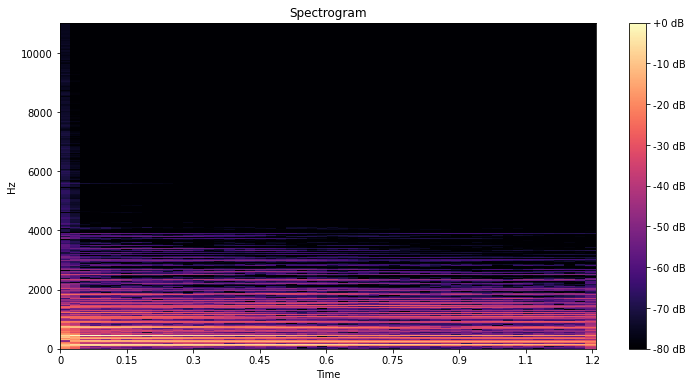

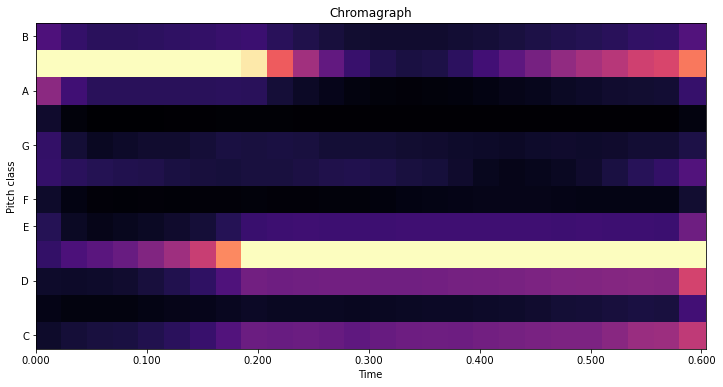

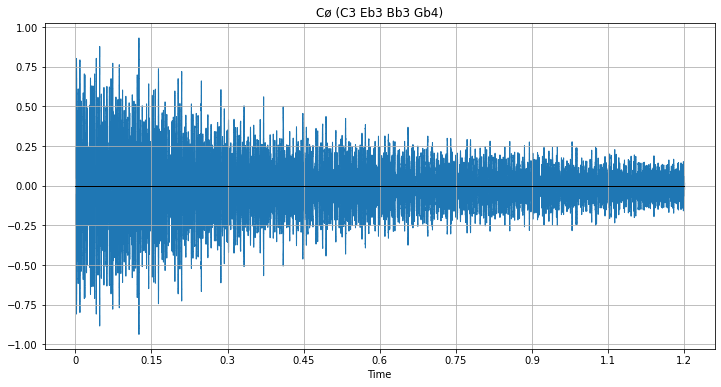


Note	Chroma Energy
C 	 0.08601229
C# 	 0.048379295
D 	 0.0879748
D# 	 0.18812522
E 	 0.15541457
F 	 0.088345855
F# 	 0.19094655
G 	 0.18941209
G# 	 0.09124589
A 	 0.40283814
A# 	 1.0
B 	 0.25002474


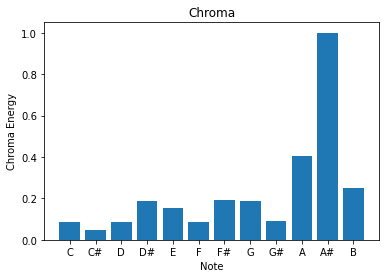

Predicted Chord:  D#m


In [113]:
c15 = x[int(53.2*SR):int(54.4*SR)]
printResults(c15, title = "Cø (C3 Eb3 Bb3 Gb4)", get_chromaDisplay = True)

This case is similar to the first Cø case.

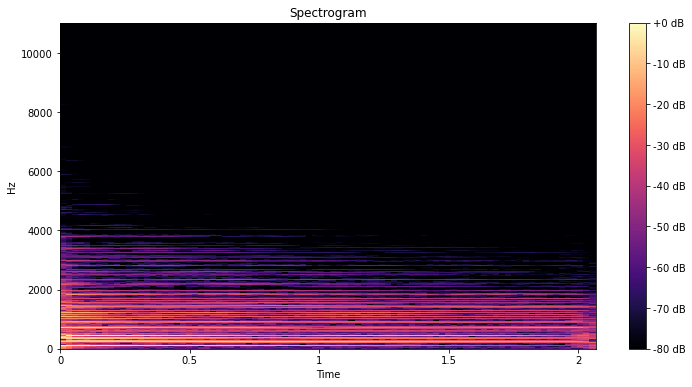

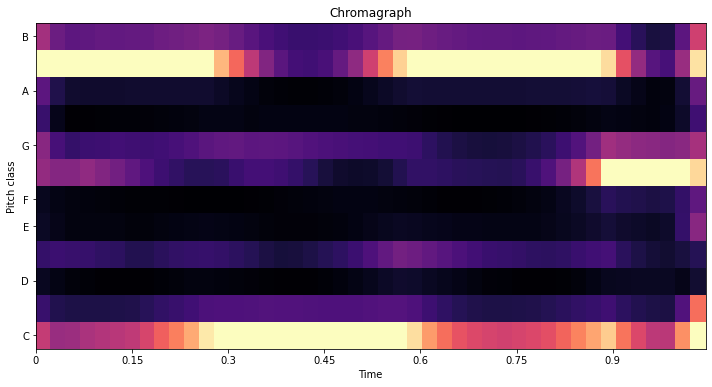

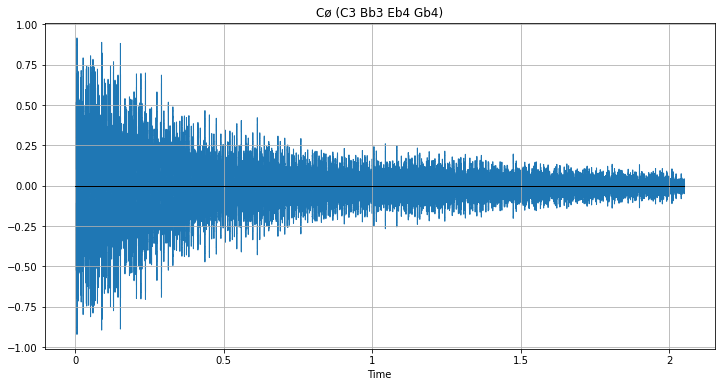


Note	Chroma Energy
C 	 0.5438396
C# 	 0.21284567
D 	 0.08319986
D# 	 0.20445798
E 	 0.09045358
F 	 0.07900601
F# 	 0.42872253
G 	 0.40396148
G# 	 0.21027759
A 	 0.29559195
A# 	 1.0
B 	 0.46600232


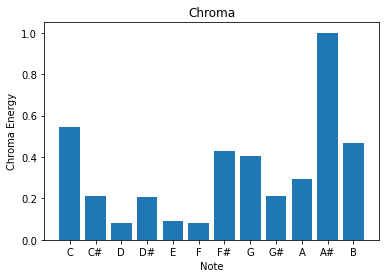

Predicted Chord:  Cø


In [117]:
c16 = x[int(55.45*SR):int(57.5*SR)]
printResults(c16, title = "Cø (C3 Bb3 Eb4 Gb4)", get_chromaDisplay = True)

This is the first example that correctly predicted Cø. In this example's chromagraph, Gb is more prominent. Through harmonic theories, the Gb helps the diminished sound of the foundational triad become more noticeable.

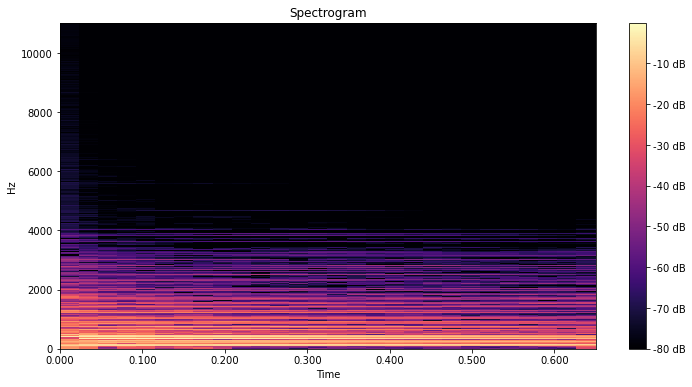

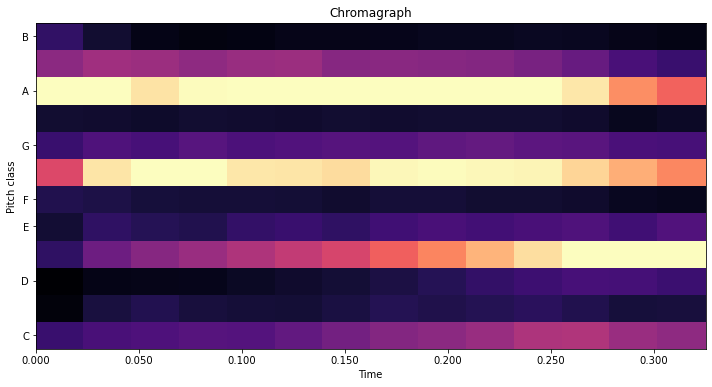

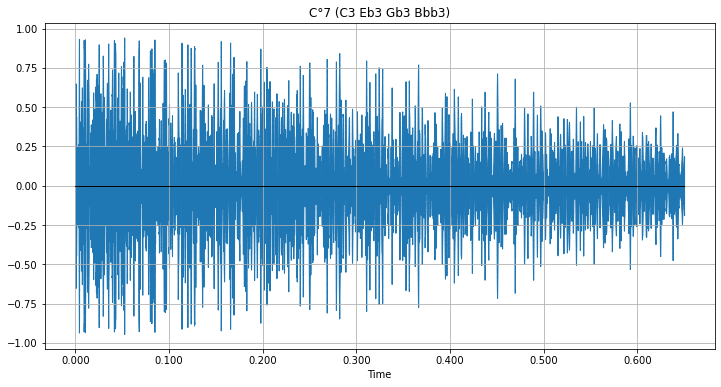


Note	Chroma Energy
C 	 0.26428467
C# 	 0.09959926
D 	 0.081475794
D# 	 0.24074405
E 	 0.16807908
F 	 0.20874898
F# 	 0.6289126
G 	 0.26291737
G# 	 0.16591866
A 	 1.0
A# 	 0.44626698
B 	 0.24590015


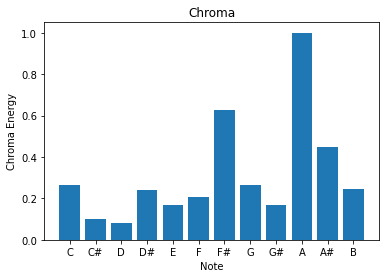

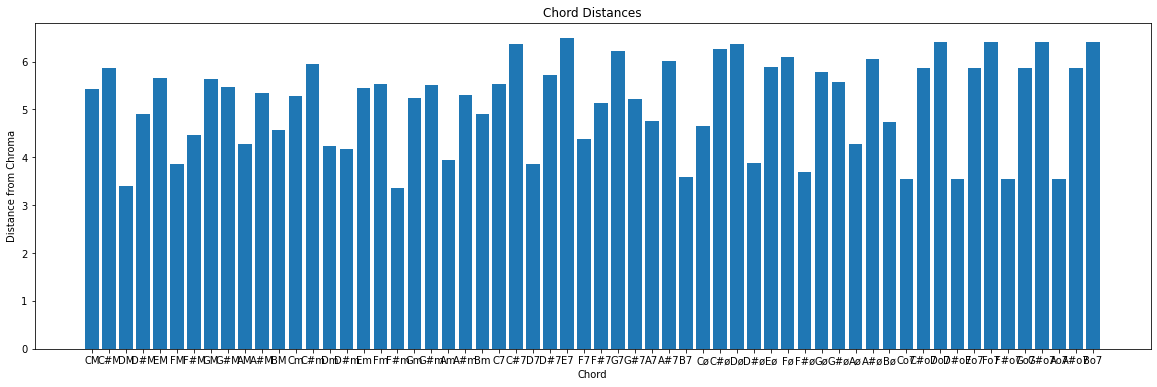


Closest template:  F#m with distance 3.3558
Predicted Chord:  F#m


In [125]:
c17 = x[int(58.65*SR):int(59.3*SR)]
printResults(c17, title = "C°7 (C3 Eb3 Gb3 Bbb3)", get_chromaDisplay = True, apply_chord_templatesDisplay = True)

The notes of an F# minor triad are: F# A C#

This can enharmonically be a Gb minor: Gb Bbb Db

This issue is similar to c14, except with Bbb instead of Bb as the overlapping note. This continues to occur in the following two examples.

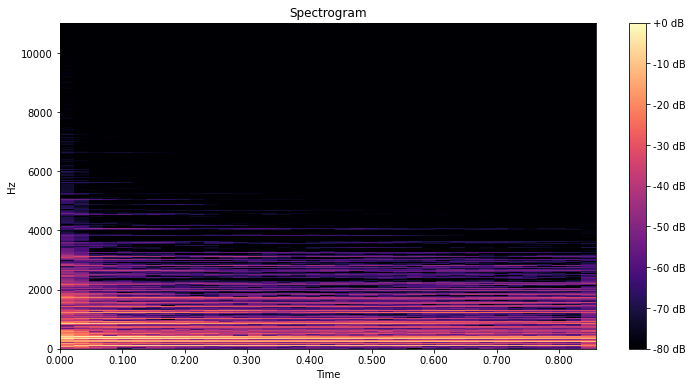

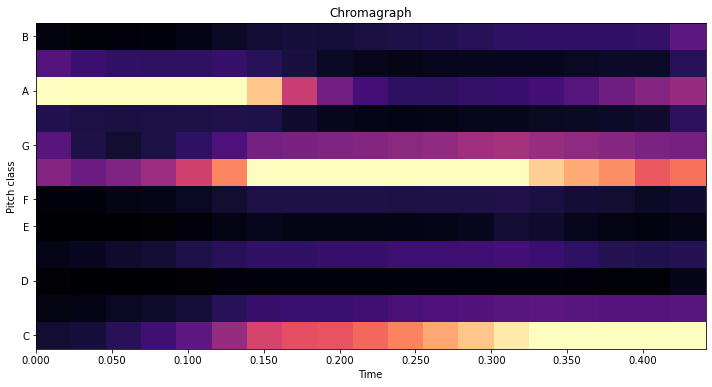

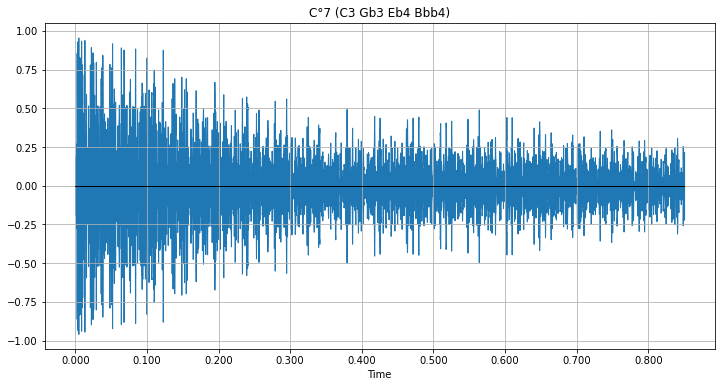


Note	Chroma Energy
C 	 0.117516614
C# 	 0.05533903
D 	 0.031922143
D# 	 0.064395525
E 	 0.02601276
F 	 0.041187353
F# 	 0.39460906
G 	 0.28590018
G# 	 0.16258118
A 	 1.0
A# 	 0.27476493
B 	 0.050863374


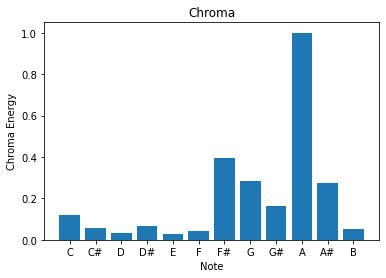

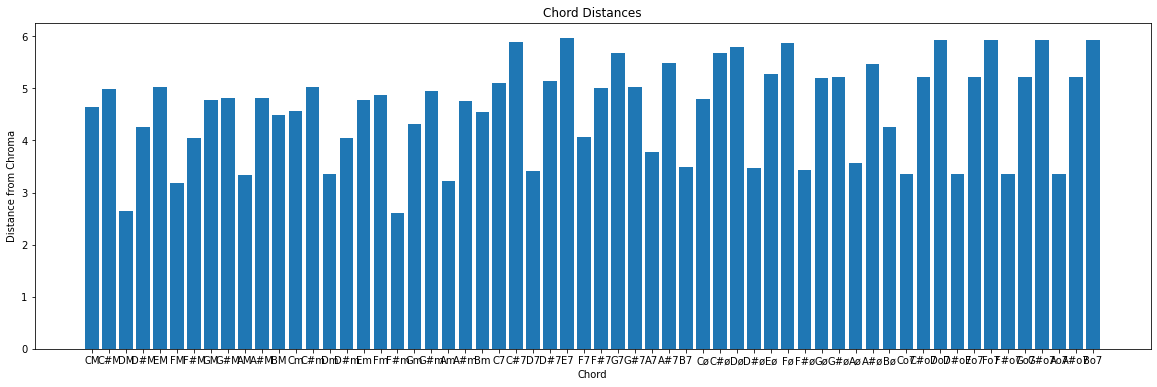


Closest template:  F#m with distance 2.6052
Predicted Chord:  F#m


In [124]:
c18 = x[int(64.85*SR):int(65.7*SR)]
printResults(c18, title = "C°7 (C3 Gb3 Eb4 Bbb4)", get_chromaDisplay = True, apply_chord_templatesDisplay = True)

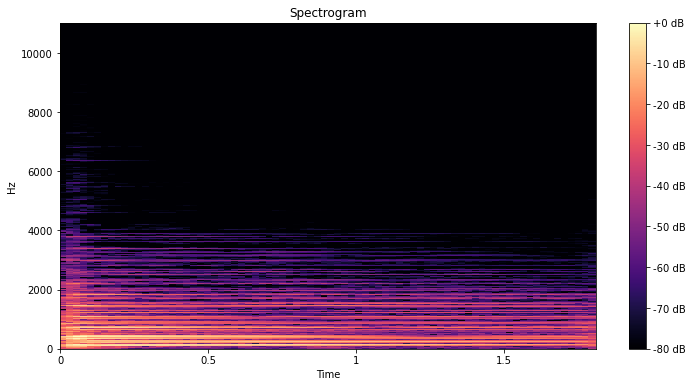

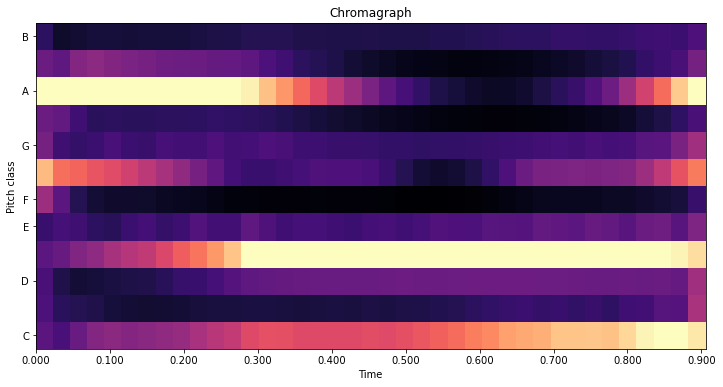

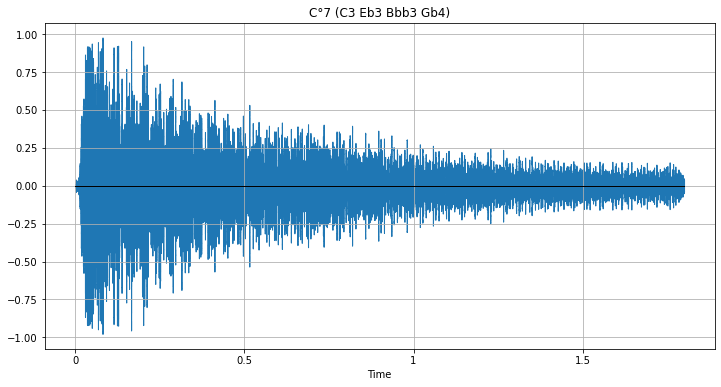


Note	Chroma Energy
C 	 0.2903947
C# 	 0.25268298
D 	 0.24631709
D# 	 0.29248962
E 	 0.21179593
F 	 0.44949535
F# 	 0.86008143
G 	 0.35314873
G# 	 0.32623082
A 	 1.0
A# 	 0.32631555
B 	 0.18451853


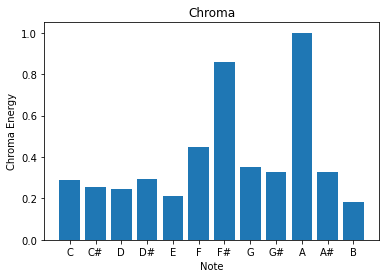

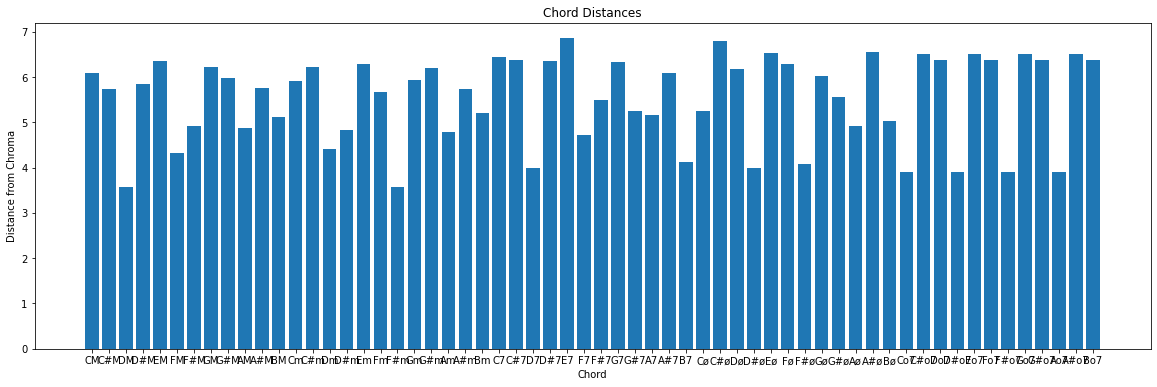


Closest template:  F#m with distance 3.5679
Predicted Chord:  F#m


In [123]:
c19 = x[int(67.1*SR):int(68.9*SR)]
printResults(c19, title = "C°7 (C3 Eb3 Bbb3 Gb4)", get_chromaDisplay = True, apply_chord_templatesDisplay = True)

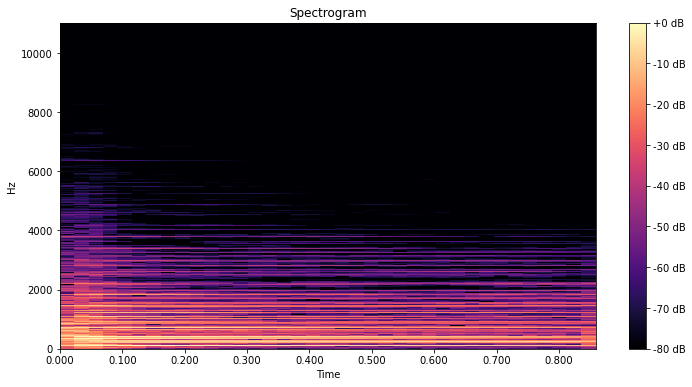

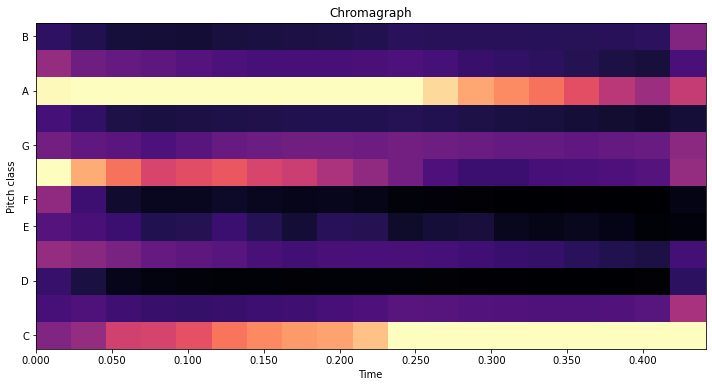

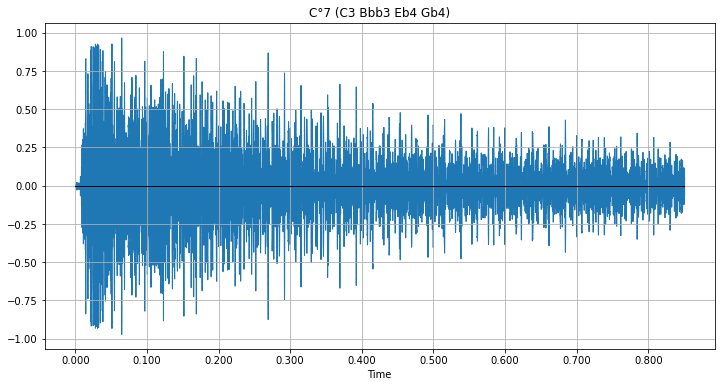


Note	Chroma Energy
C 	 0.38578308
C# 	 0.24937414
D 	 0.21221912
D# 	 0.43476814
E 	 0.27955517
F 	 0.4233759
F# 	 1.0
G 	 0.35258815
G# 	 0.24427225
A 	 0.99212843
A# 	 0.436649
B 	 0.19629668


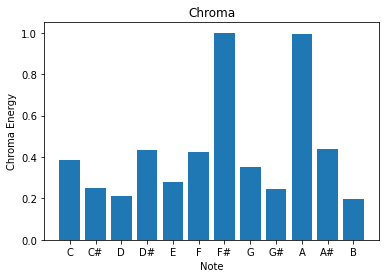

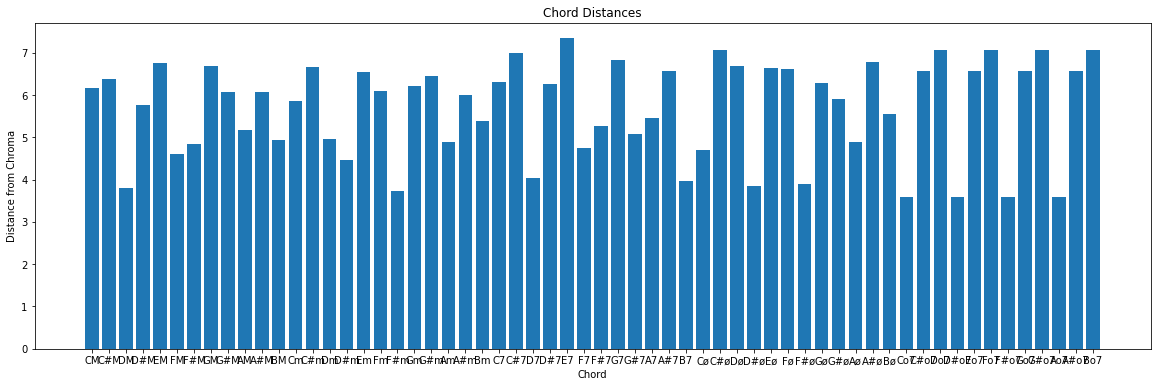


Closest template:  Co7 with distance 3.5817
Predicted Chord:  Co7


In [122]:
c20 = x[int(69.35*SR):int(70.2*SR)]
printResults(c20, title = "C°7 (C3 Bbb3 Eb4 Gb4)", get_chromaDisplay = True, apply_chord_templatesDisplay = True)

This is the first correctly predicted Co7. In this example, the C and Eb chromas are most prominent, which helps distinguish the Co7 chord. However, looking at the previous chormagraphs, the C and Eb seem to be acknowledged. To possibly solve this issue in the future, we could try find more correlation between the Chromagraph and Chroma values.

Below, we begin to analyze chords outside of C. The next two examples show that the chord predictions are often correct for major minor, and seventh chords.

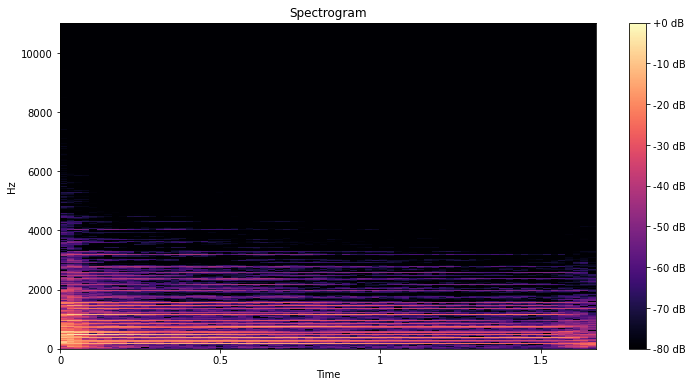

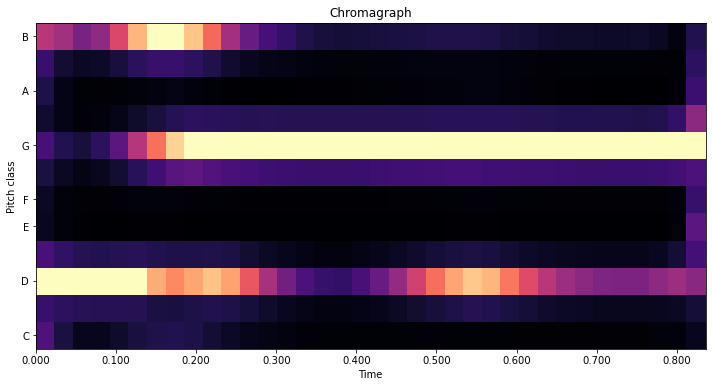

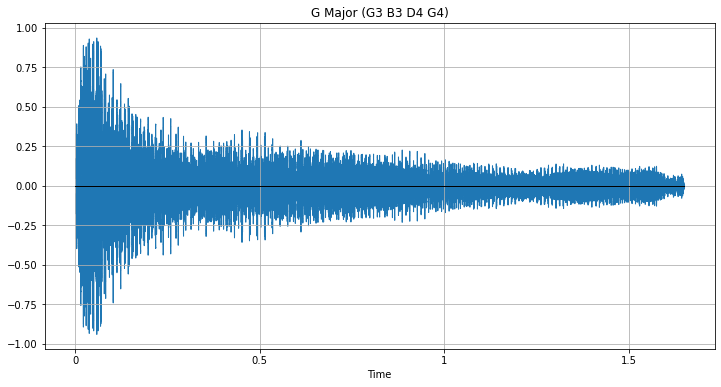

Predicted Chord:  GM


In [126]:
c21 = x[int(74.3*SR):int(75.95*SR)]
printResults(c21, title = "G Major (G3 B3 D4 G4)")

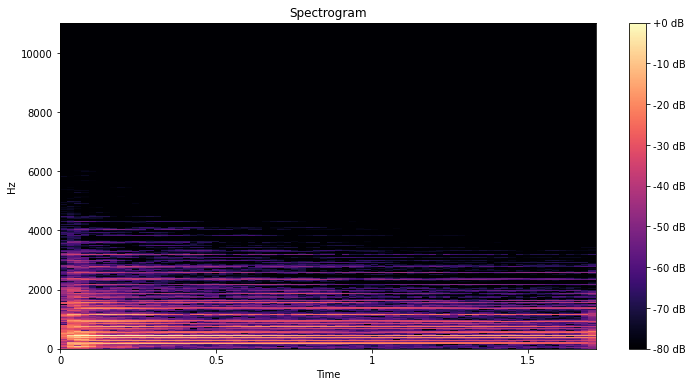

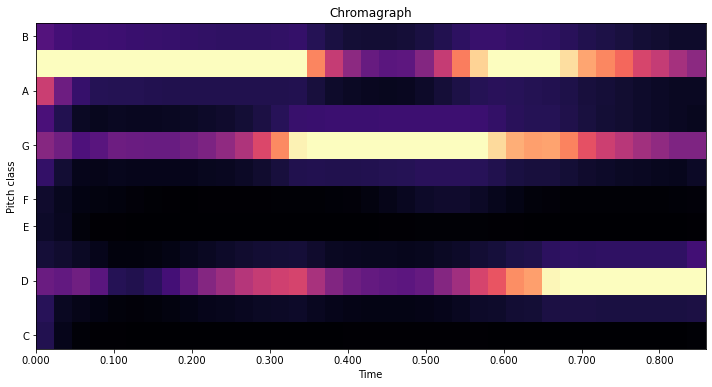

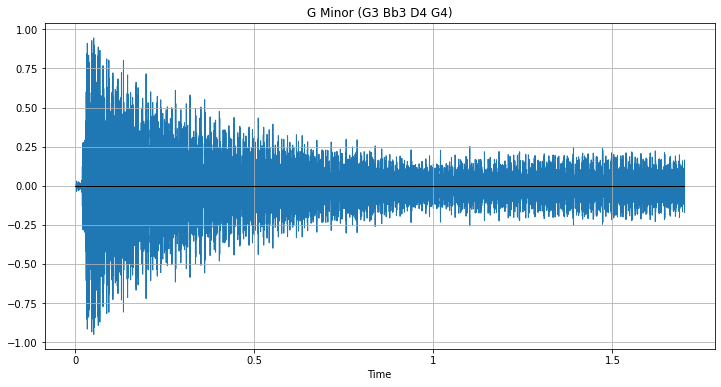

Predicted Chord:  Gm


In [127]:
c22 = x[int(76.3*SR):int(78*SR)]
printResults(c22, title = "G Minor (G3 Bb3 D4 G4)")

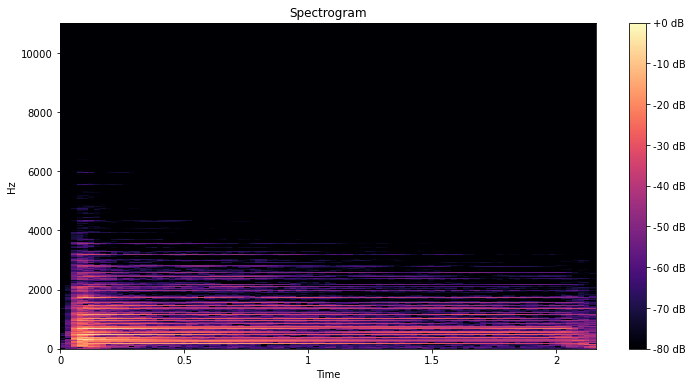

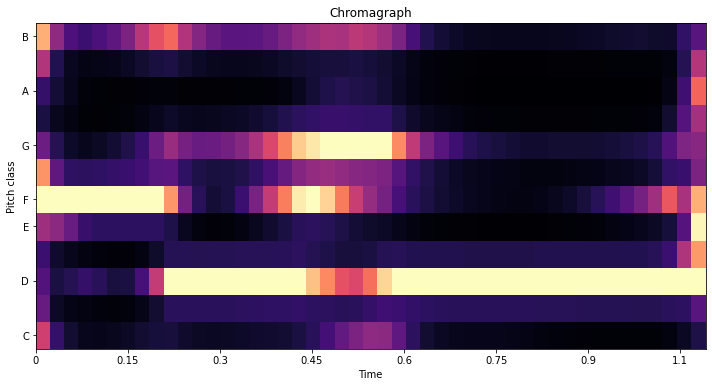

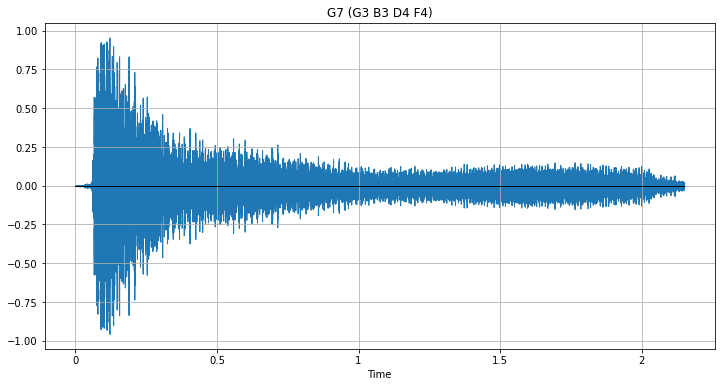

Predicted Chord:  G7


In [128]:
c23 = x[int(79.15*SR):int(81.3*SR)]
printResults(c23, title = "G7 (G3 B3 D4 F4)")


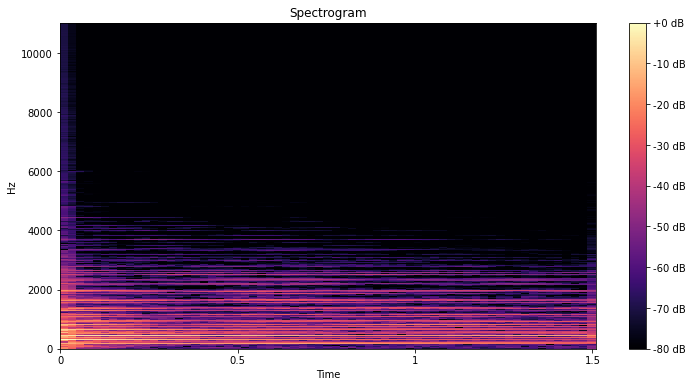

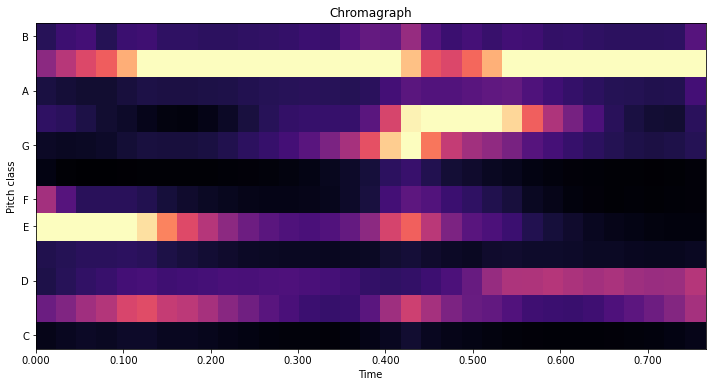

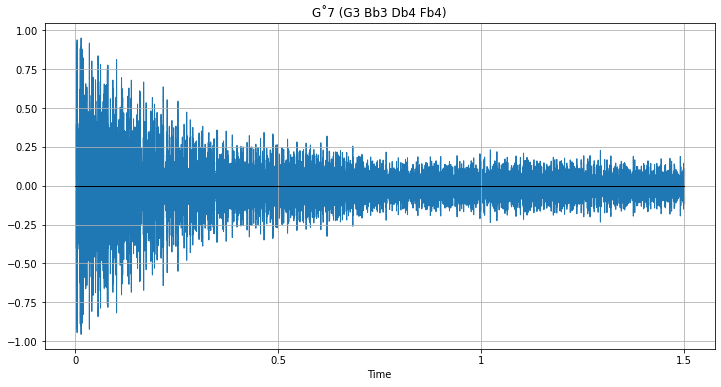

Predicted Chord:  C#m


In [129]:
c24 = x[int(85.2*SR):int(86.7*SR)]
printResults(c24, title = "G˚7 (G3 Bb3 Db4 Fb4)")

C#m is enharmonically Dbm which is spelled: Db Fb Ab

The algorithm picked up Db and Fb, but not Bb (which could have resulted in a Bb minor chord) or G (which could have given the correct root and possibly the correct chord prediction as well).

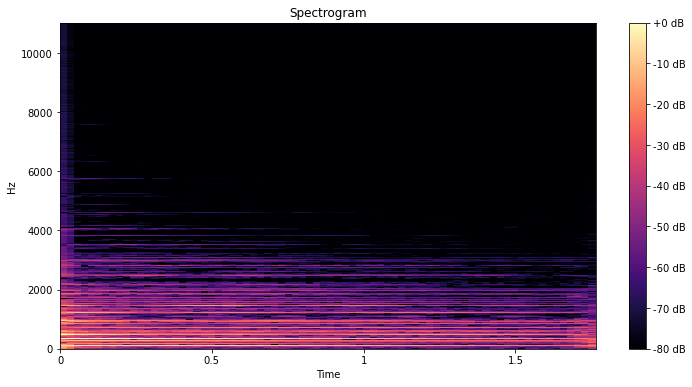

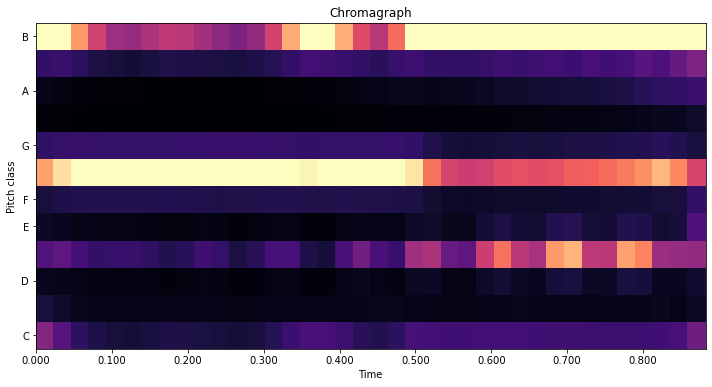

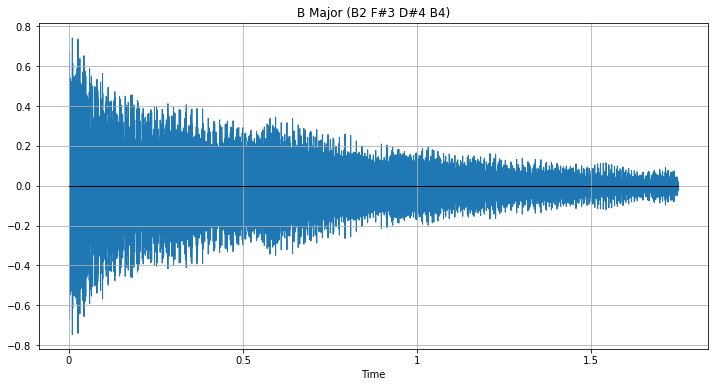

Predicted Chord:  BM


In [130]:
c25 = x[int(91.35*SR):int(93.1*SR)]
printResults(c25, title = "B Major (B2 F#3 D#4 B4)")

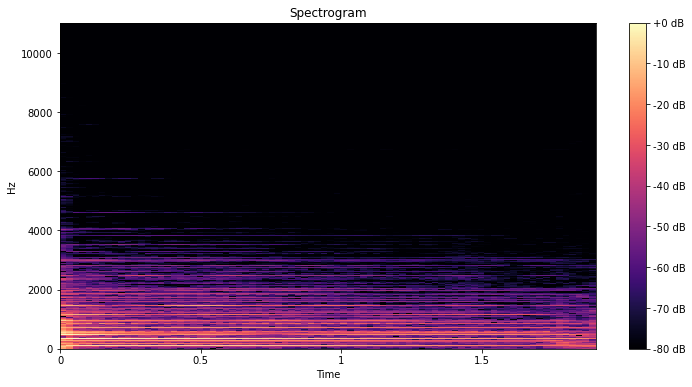

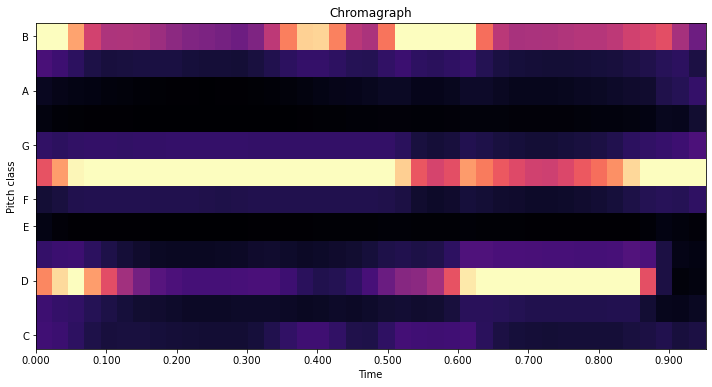

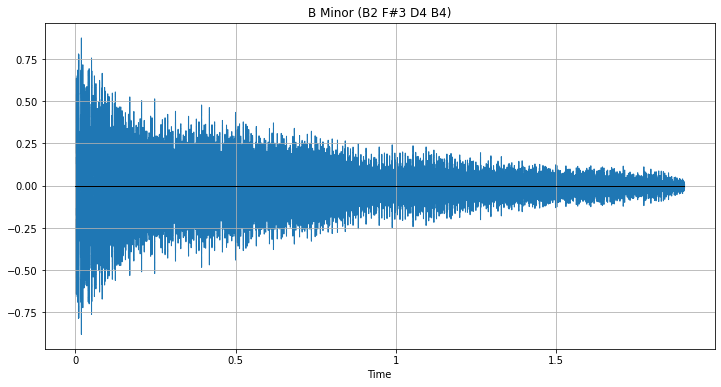

Predicted Chord:  Bm


In [131]:
c26 = x[int(94.65*SR):int(96.55*SR)]
printResults(c26, title = "B Minor (B2 F#3 D4 B4)")

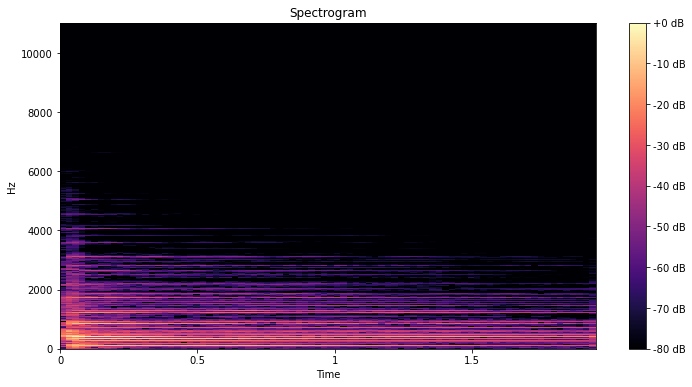

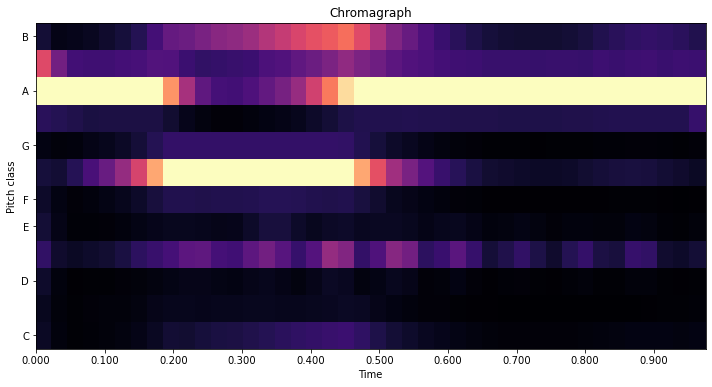

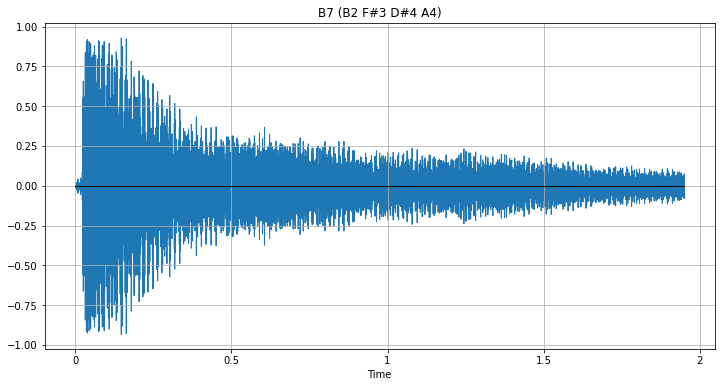


Note	Chroma Energy
C 	 0.07597666
C# 	 0.063451014
D 	 0.08636906
D# 	 0.18225951
E 	 0.10615937
F 	 0.08390443
F# 	 0.11250609
G 	 0.041872695
G# 	 0.16511203
A 	 1.0
A# 	 0.60434425
B 	 0.10595286


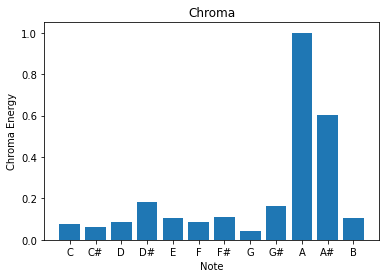

Predicted Chord:  DM


In [133]:
c27 = x[int(96.95*SR):int(98.9*SR)]
printResults(c27, title = "B7 (B2 F#3 D#4 A4)", get_chromaDisplay = True)

D major triad is spelled: D F# A

B seventh is spelled: B D# F# A

DM shares overlap with B7. The main issue is that the algorithm did not pick up on the B, which is the root of the chord.
    

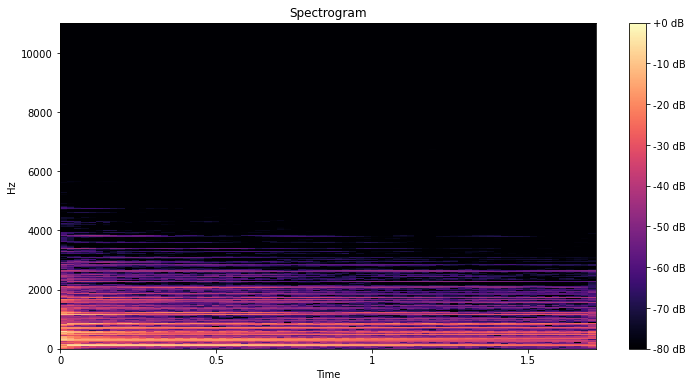

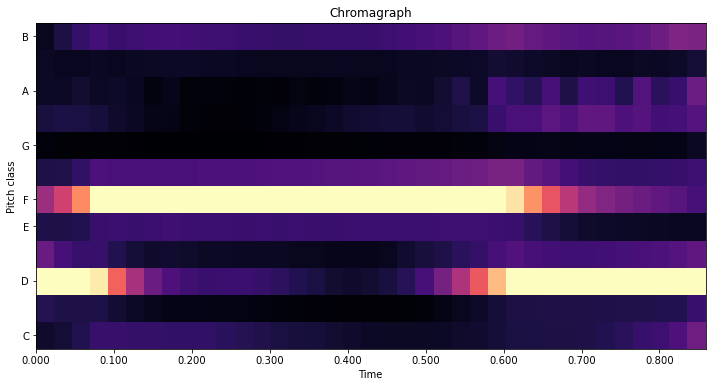

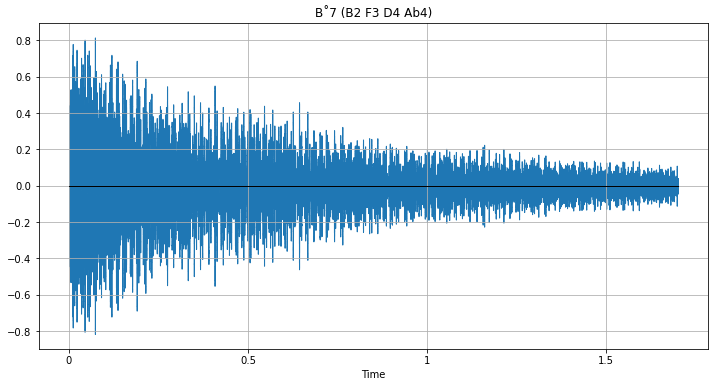

Predicted Chord:  Dm


In [134]:
c28 = x[int(100.3*SR):int(102*SR)]
printResults(c28, title = "B˚7 (B2 F3 D4 Ab4)")

Same issue as c27, but with F natural instead of F#.

The next examples test chords progressions, which include multiple related but different chords. 
The following code is from HW3:

In [135]:
def rectify(A):
    return np.maximum(A,np.zeros(len(A)))

# FFT
def realFFT(X):
    return 2*abs(np.fft.rfft(X))/len(X) 

# finds spectral distance
def spectral_distance(S,Sn,kind='L2'):      # default is L2 norm
    S = np.abs(S)          # just use magnitude of complex values
    Sn = np.abs(Sn)
    if(kind == 'L1'):
        return np.sum(np.abs(Sn-S))
    elif(kind == 'L2'):
        return (np.sum((Sn-S)**2))**0.5
    elif(kind == 'CD'):                     # Correlation Distance:  1 - correlation
        s = np.std(S)                       # must account for spectra with all 0's
        sn = np.std(Sn)
        if(np.isclose(s,0) or np.isclose(sn,0)):
            return 0.0
        else:
            return 1.0 - (((S - np.mean(S)) @ (Sn - np.mean(Sn))) / (len(S) * s * sn))
    elif(kind == 'RL1'):
        return np.sum(np.abs(rectify(Sn-S)))
    elif(kind == 'RL2'):
        return (np.sum(rectify(Sn-S)**2))**0.5               
    else:
        return None

# onset detection
def SpectralBasedOnsets(X,window_size=512,hop_length=256,
                        kind = None,     # distance function used, L1, L2, CD, SF1, SF2
                        filtr = None,    # filter applied before peak picking, if any, from ('MAF','sMAF','MF','sMF')
                        size = 3,        # size of kernel used in filter, if any
                        win = None,      # apply windowing function to window, if any ('hann','tri')
                        scale=None,      # scale factor for log, None = no log
                        height=None,     # these 3 parameters are for pick_peak,
                        prominence=None, # any not equal to None will be applied
                        distance=None,
                        displayAll=False):
    
    # Normalize amplitude of X so maximum is 1.0
    X = X / np.max(X)
    
    # windowing 
    if win!= None:
        win_size = len(X)
        if win == 'hann':
            X = X * windows.hann(win_size)
        else:
            X = X * windows.triang(win_size)
    
    X_energy = []           
    counter = 0
    while (counter <= (len(X) - window_size)):
        X_energy.append(realFFT(np.array(X[counter : counter + window_size])))
        counter += hop_length
    X_energy = np.array(X_energy) # array of arrays

    
    if(displayAll):
        plt.figure(figsize=(12,4))
        plt.title("X Energy Signal")
        plt.plot(X_energy)
        plt.show()

    # take the log with scaling factor:   np.log(1.0 + scale * X_energy)
    # if scale = None, do nothing

    if(scale == None):
        X_spectrogram = X_energy
    else:
        X_spectrogram = np.array([np.log(1.0 + scale * np.abs(k)) for k in X_energy])
    
    

    if(displayAll):
        plt.figure(figsize=(12,4))
        plt.title("Log X Energy Signal with scale factor "+str(scale))
        plt.plot(X_spectrogram)
        plt.show()

    # Calculate the novelty function (first difference) using np.diff(...)
    # Watch out:  np.diff(...) changes the array IN PLACE, so make a copy beforehand if you want
    # (debugging is easier if you have all the successive arrays)
    
    # Optional: add 0 at beginning before taking difference so have exactly the same number of values as X_energy
      
    num_windows = len(X_spectrogram)
    X_spectral_novelty = np.zeros(num_windows)

    for k in range(1,num_windows):           #first value will be 0, length unchanged
        X_spectral_novelty[k] = spectral_distance(X_spectrogram[k-1],X_spectrogram[k],kind)    
    
    if(displayAll):
        plt.figure(figsize=(12,4))
        plt.title("X Spectral Novelty")
        plt.plot(X_spectral_novelty)
        plt.show()
        
    # peak picking using parameters from the argument list: height, prominence, and distance
    X_energy_novelty_rectified = rectify(X_spectral_novelty)
    peaks,_ = find_peaks(X_energy_novelty_rectified,height=height,prominence=prominence,distance=distance)   
    
    if (displayAll):
        plt.figure(figsize=(12,4))
        plt.title("Picking Peaks")
        plt.plot(peaks, X_energy_novelty_rectified[peaks], "or")
        plt.plot(X_energy_novelty_rectified)
        plt.show() 
    

    onsets = []  
    for window_index in peaks:
        onsets.append((window_index * hop_length) + int(window_size/2))
        
    onsets = np.array(onsets)
    
    if (displayAll):
        plt.figure(figsize=(12,4))
        plt.title("Signal with Onsets")
        plt.plot(X)  
        for k in range(len(onsets)):
            plt.plot([onsets[k],onsets[k]],[-1,1],color='r')    
        plt.show()
    
    clicks = librosa.clicks(times=onsets/SR, sr=SR, hop_length=hop_length, length=len(X))
    
    return (onsets, clicks)

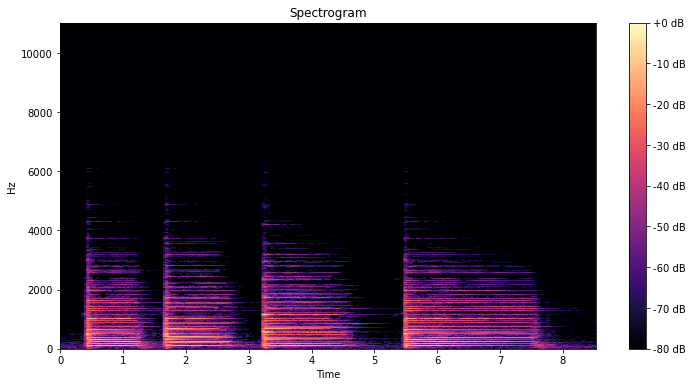

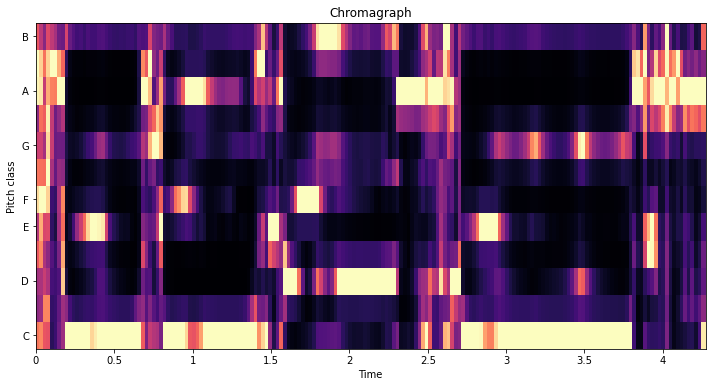

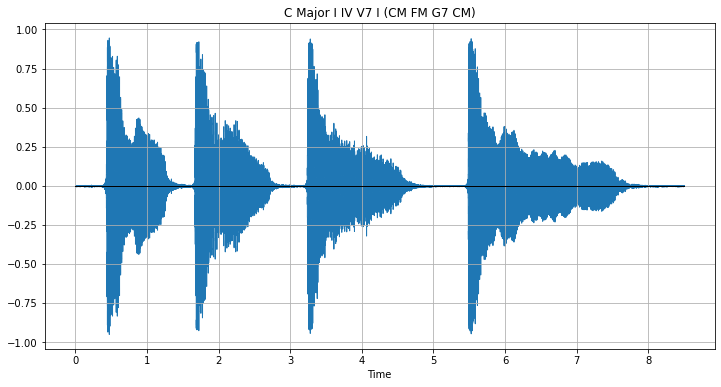

In [136]:
cp29 = x[int(141*SR):int(149.5*SR)]

displaySpectroChroma(x = cp29)

displaySignal(cp29, title="C Major I IV V7 I (CM FM G7 CM)")
display(Audio(cp29, rate=sr))


In [140]:
# using the chord templates like before, but now with successive chords
(onsets,_) = SpectralBasedOnsets(cp29,window_size=512,hop_length=256,
                                kind = 'L1',     # distance function used, L1, L2, CD, SF1, SF2
                                filtr = 'sMAF',    # filter applied before peak picking, if any
                                size = 3,        # size of kernel used in filter
                                win = None,      # apply windowing function to window
                                scale=10,      # scale factor for log, None = no log
                                height=10,     # these 3 parameters are for pick_peak,
                                prominence=0.3, #    any not equal to None will be applied
                                distance=100,
                                displayAll=False)
def find_chords(signal, onsets, offset, chord_length):
    onsets_ = onsets + (offset*SR) 
    for onset in onsets_:
        (chord, _) = apply_chord_templates(get_chroma(signal[int(onset) : int(onset+(chord_length*SR))], display = False),dist="L1", display = False)
        print(chord) 

find_chords(cp29, onsets, 0.2, 0.4)




CM
FM
A#M
CM


Because this project is not focused on beat recognition, we changed these parameters manually to get more accurate onsets. Based on our expreience with the above examples, we know that noise right before chords mess with the algorithm. We would begin looking at the middle of the chord sound by using <i>offset</i>. In addition, we used <i>chord_length</i> to cut noise after the chord. 

Regardless how <i>find_chords</i> was adjusted, the third chord was always wrong. The chord keeps getting registered as A# major; this is because the notes shared by G7 and A#M are D and F. This may be because the chord was played in an inversion, where the bass note (B) was overshadowed. In the future, we could use a comb filter to possibly better distinguish the bass note.

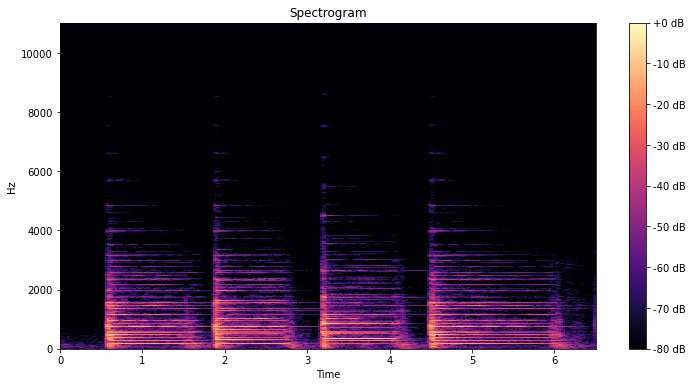

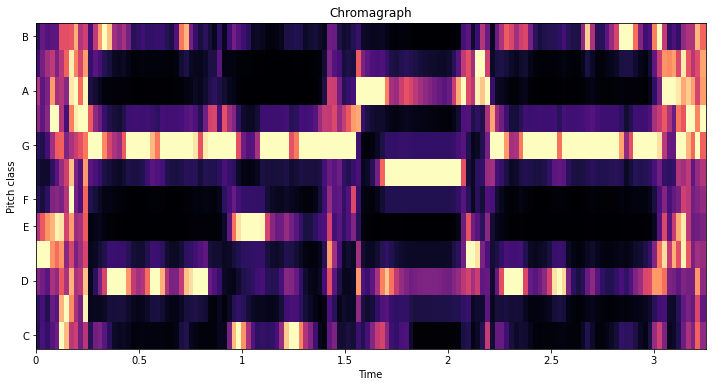

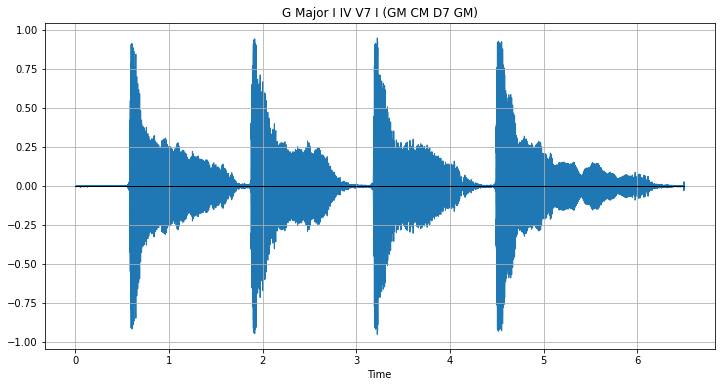

In [141]:
cp30 = x[int(150*SR):int(156.5*SR)]

displaySpectroChroma(x = cp30)

displaySignal(cp30, title="G Major I IV V7 I (GM CM D7 GM)")
Audio(cp30, rate=sr)

In [144]:
(onsets,_) = SpectralBasedOnsets(cp30,window_size=512,hop_length=256,
                                kind = 'L1',     # distance function used, L1, L2, CD, SF1, SF2
                                filtr = 'sMAF',    # filter applied before peak picking, if any
                                size = 3,        # size of kernel used in filter
                                win = None,      # apply windowing function to window
                                scale=10,      # scale factor for log, None = no log
                                height=10,     # these 3 parameters are for pick_peak,
                                prominence=0.3, #    any not equal to None will be applied
                                distance=100,
                                displayAll=False)
def find_chords(signal, onsets, offset, chord_length):
    onsets_ = onsets + (offset*SR) 
    for onset in onsets_:
        (chord, _) = apply_chord_templates(get_chroma(signal[int(onset) : int(onset+(chord_length*SR))], display = False),dist="L1", display = False)
        print(chord) 

find_chords(cp30, onsets, 0.2, 0.3)

GM
CM
DM
GM


This prediction is much closer. The algorithm only missed one note in this chord progressions: the seventh of the D7, C.

In the future we can further experiment with more complicated music. If we were to do that, we could apply music theory concepts to more easily find chord progressions. A lot of music follows a similar chord progression such as the ones in the last two examples. There is generally a strong relationship between the main key of a progression (usually notated with I or one, and called tonic), and the chord of the key seven half steps above the tonic (usually notated with V or 5, and called dominant). When a dominant is heard, it typically leads back to the tonic rather than to other chords. Knowing this as well as other theory concepts could help reduce some errors in the algorithm.

We could also interpret more using the frequency of prominent pitches, and possibly distinguish the bass and even inversions of the chord. Before doing that, we could try to improve the current algorithm by applying a comb filter, manipulating the chroma analysis, and allowing it to accept an optional bass note parameter.